Research Experiments IOT version 5.0 - PUBLIC DATA
Yavuz Selim Hindistan, E. Fatih Yetkin 2021 August

In [1]:
#pip install plotly_express==0.4.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from ctgan import CTGANSynthesizer
from warnings import simplefilter
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Dataset Public Data=Toy Data

dataset_iot_toy =pd.read_csv('sample_dataset/toy_scada_data.csv', delimiter=',',
                             error_bad_lines=False, header=0, na_values='-',na_filter=False)

dataset_iot_toy['DateTime'] = pd.to_datetime(dataset_iot_toy.iloc[:,0])
dataset_iot_toy = dataset_iot_toy.loc[(dataset_iot_toy.iloc[:,0].dt.year ==2014) & (dataset_iot_toy.iloc[:,0].dt.month <=6) ]
dataset_iot_toy = dataset_iot_toy[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
                                   'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours',
                                   'WEC: Production kWh']]
#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
dataset_iot_toy.iloc[:,:] = min_max_scaler.fit_transform(dataset_iot_toy.iloc[:,:])

Toy_data=dataset_iot_toy.iloc[:,:].copy()
Toy_data


WEC: ava. windspeed  WEC: ava. Rotation  WEC: ava. Power  \
0                0.291139            0.000000         0.000000   
1                0.223629            0.000000         0.000000   
2                0.210970            0.000000         0.000000   
3                0.185654            0.000000         0.000000   
4                0.240506            0.000000         0.000000   
...                   ...                 ...              ...   
8650             0.261603            0.591712         0.160586   
8651             0.240506            0.566576         0.136482   
8652             0.261603            0.610734         0.178502   
8653             0.270042            0.631793         0.199349   
8654             0.295359            0.663043         0.229967   

      WEC: ava. reactive Power  WEC: ava. available P from wind  \
0                     0.125000                         0.272964   
1                     0.125000                         0.144300   
2                     0.125000                         0.171010   
3                     0.125000                         0.081433   
4                     0.125000                         0.178827   
...                        ...                              ...   
8650                  0.421875                         0.161238   
8651                  0.437500                         0.136808   
8652                  0.437500                         0.177524   
8653                  0.421875                         0.200000   
8654                  0.390625                         0.228990   

      WEC: Operating Hours  WEC: Production kWh  
0                      0.0             0.000000  
1                      0.0             0.000000  
2                      0.0             0.000000  
3                      0.0             0.000000  
4                      0.0             0.000000  
...                    ...                  ...  
8650                   1.0             0.999415  
8651                   1.0             0.999523  
8652                   1.0             0.999662  
8653                   1.0             0.999819  
8654                   1.0             1.000000  

[8655 rows x 7 columns]

Xtoy_train.shape: (6924, 6) ; ytoy_train.shape: (6924, 1) ; Xtoy_test.shape: (1731, 6) ; ytoy_test.shape: (1731, 1)
intercept [-0.03094196] coefficients [[ 0.16119228 -0.0819185   0.09631101  0.0164332  -0.06675797  1.1401929 ]] coefftoy.shape (1, 6) R-Squared score public dataset: 0.9689236047505994 mean_absolute_error: 0.049531355284189706


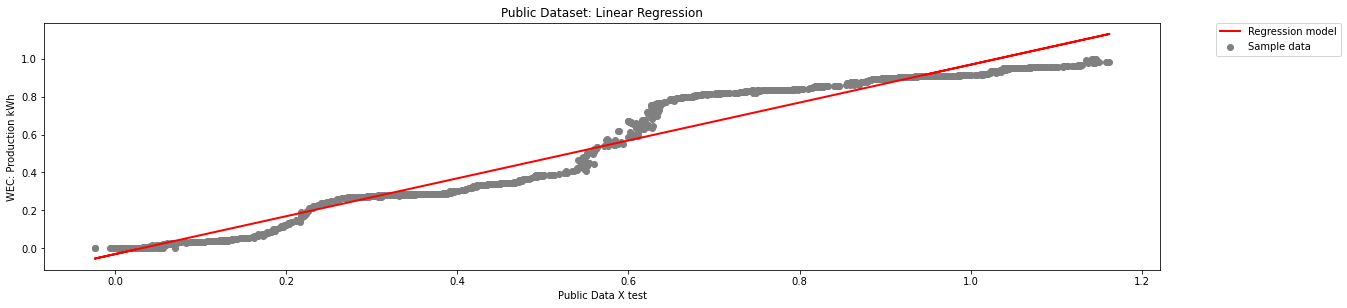

In [3]:
#Linear Regression
ytoy = Toy_data[['WEC: Production kWh']]
Xtoy = Toy_data[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
                 'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours']]
Xtoy_train, Xtoy_test, ytoy_train, ytoy_test = train_test_split(Xtoy, ytoy, test_size=0.2, random_state=0)
print('Xtoy_train.shape:', Xtoy_train.shape, '; ytoy_train.shape:', ytoy_train.shape, 
      '; Xtoy_test.shape:', Xtoy_test.shape, '; ytoy_test.shape:', ytoy_test.shape)

#Linear Regression for Toy Dataset
lin_regtoy = LinearRegression()  
reg_modeltoy = lin_regtoy.fit(Xtoy_train, ytoy_train)
intercepttoy = lin_regtoy.intercept_
coefftoy = lin_regtoy.coef_
ytoy_pred = lin_regtoy.predict(Xtoy_test)
#accuracytoy = reg_modeltoy.score(Xtoy_test, ytoy_test)
r2scoretoy = reg_modeltoy.score(Xtoy_test, ytoy_test)
MAEtoy = mean_absolute_error(ytoy_test, ytoy_pred)

print('intercept', intercepttoy, 
      'coefficients', coefftoy, 
      'coefftoy.shape', coefftoy.shape,
      'R-Squared score public dataset:', r2scoretoy,
      'mean_absolute_error:', MAEtoy)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 1, 1)
ax1.set_title('Public Dataset: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('WEC: Production kWh')
plt.scatter(Xtoy_test.dot(coefftoy.squeeze()), ytoy_test, label= 'Sample data ',  color='gray')
plt.plot(Xtoy_test.dot(coefftoy.squeeze()), ytoy_pred, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show();

### Privacy Metrics Definitions

In [4]:
def Privacy_Metric(array1, array2, plot=False):
    output_list_PM = pd.DataFrame([])
    fig = plt.figure(figsize=(12, 18))
    plot_number = 1
    for i in np.arange(0,array1.shape[1],1): 
        ax1 = plt.subplot(array1.shape[1], 2, plot_number)
        ax1.set_title( array1.columns[i] + ' Feature: %d' % i)
        values, bins, _ = plt.hist(x=array1.iloc[:,i], label =array1.columns[i], bins='auto', color='blue')
        area_array1 = sum(np.diff(bins)*values)
        plt.ylabel('Frequency')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plot_number += 1
        ax2 = plt.subplot(array1.shape[1], 2, plot_number)
        ax2.set_title(array2.columns[i] + ' Feature: %d' % i) 
        values, bins, _ = plt.hist(x=array2.iloc[:,i], label = array2.columns[i], bins='auto', color='brown')
        area_array2 = sum(np.diff(bins)*values)
        plt.ylabel('Frequency')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plot_number += 1
        output_list_PM = output_list_PM.append(
            pd.DataFrame({'F_Nb':[i],
                            'PDF_1':[round(area_array1,2)],
                            'PDF_2':[round(area_array2,2)], 
                            'PDF_Diff_Perc':[round(abs(area_array1-area_array2)/area_array1,2)],
                            'MeanSqErr':[round(mean_squared_error(array1.iloc[:,i],array2.iloc[:,i]),2)],
                            'NormVar':[round(np.var(array1.iloc[:,i]-array2.iloc[:,i])/np.var(array1.iloc[:,i]),2)],
                            'PearsonCC':[round(pearsonr(array1.iloc[:,i],array2.iloc[:,i])[0],2)]},
                         index=[0]), ignore_index=True)
        ax1.get_shared_x_axes().join(ax1, ax2)
        ax1.get_shared_y_axes().join(ax1, ax2)
        ax1.autoscale()
        ax2.autoscale()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6, wspace=0.6) 
    if plot:
        plt.show();
    else:
        plt.close()    
        
    return output_list_PM

### GAN Calculations

In [5]:
#CTGAN
simplefilter(action='ignore')
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(Toy_data, epochs = 100)

Epoch 1, Loss G: -0.2526,Loss D:  0.2637
Epoch 2, Loss G: -0.5994,Loss D: -1.0802
Epoch 3, Loss G: -0.6517,Loss D:  0.2027
Epoch 4, Loss G: -0.7418,Loss D:  0.0987
Epoch 5, Loss G: -0.5156,Loss D: -0.2308
Epoch 6, Loss G: -0.1285,Loss D: -0.2388
Epoch 7, Loss G:  0.1863,Loss D: -0.7706
Epoch 8, Loss G:  0.5631,Loss D: -1.1970
Epoch 9, Loss G:  1.0455,Loss D: -1.1254
Epoch 10, Loss G:  1.9534,Loss D: -2.7197
Epoch 11, Loss G:  2.5873,Loss D: -4.1040
Epoch 12, Loss G:  2.8464,Loss D: -5.4455
Epoch 13, Loss G:  2.8228,Loss D: -5.6118
Epoch 14, Loss G:  2.7504,Loss D: -5.6830
Epoch 15, Loss G:  3.0491,Loss D: -6.7445
Epoch 16, Loss G:  3.0977,Loss D: -7.5905
Epoch 17, Loss G:  3.2293,Loss D: -8.3067
Epoch 18, Loss G:  3.2003,Loss D: -9.6354
Epoch 19, Loss G:  3.3784,Loss D: -9.8429
Epoch 20, Loss G:  3.3753,Loss D: -10.2011
Epoch 21, Loss G:  3.5817,Loss D: -10.8440
Epoch 22, Loss G:  3.5459,Loss D: -11.0703
Epoch 23, Loss G:  3.6232,Loss D: -12.4442
Epoch 24, Loss G:  3.8846,Loss D: -13.8

In [6]:
Toy_data_GAN = ctgan.sample(Toy_data.shape[0])
Toy_data_GAN

WEC: ava. windspeed  WEC: ava. Rotation  WEC: ava. Power  \
0                0.193108            0.837264         0.393027   
1                0.447865            0.002421         0.063874   
2                0.041665            0.674176         0.495238   
3                0.293492            0.014814         0.069180   
4                0.300304            0.641185         0.488046   
...                   ...                 ...              ...   
8650             0.267342            0.095779         0.868093   
8651             0.342497            0.474441         0.728886   
8652             0.052876           -0.001081        -0.009312   
8653             0.492965            0.226895         1.180062   
8654             0.359472           -0.004355         0.378722   

      WEC: ava. reactive Power  WEC: ava. available P from wind  \
0                     0.512494                         0.654556   
1                    -0.007127                         0.374209   
2                     0.566852                         0.275485   
3                    -0.042643                         0.023560   
4                     0.232664                         0.932506   
...                        ...                              ...   
8650                  0.936302                         0.046619   
8651                  0.547876                         0.183576   
8652                  0.464052                         0.135855   
8653                  0.044151                         0.229036   
8654                  0.141126                         0.604519   

      WEC: Operating Hours  WEC: Production kWh  
0                -0.032436            -0.012356  
1                 0.205522             0.720938  
2                 0.478546             0.554464  
3                 0.164345             0.969925  
4                 0.756086             0.049032  
...                    ...                  ...  
8650              0.953205             1.004202  
8651              0.217952             0.241587  
8652             -0.062161             0.674905  
8653              0.685752             0.627749  
8654              0.135981             0.337421  

[8655 rows x 7 columns]

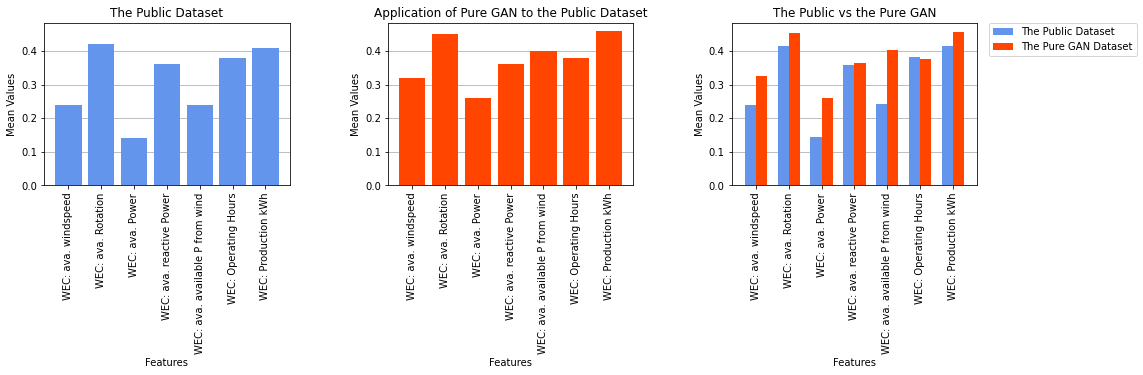

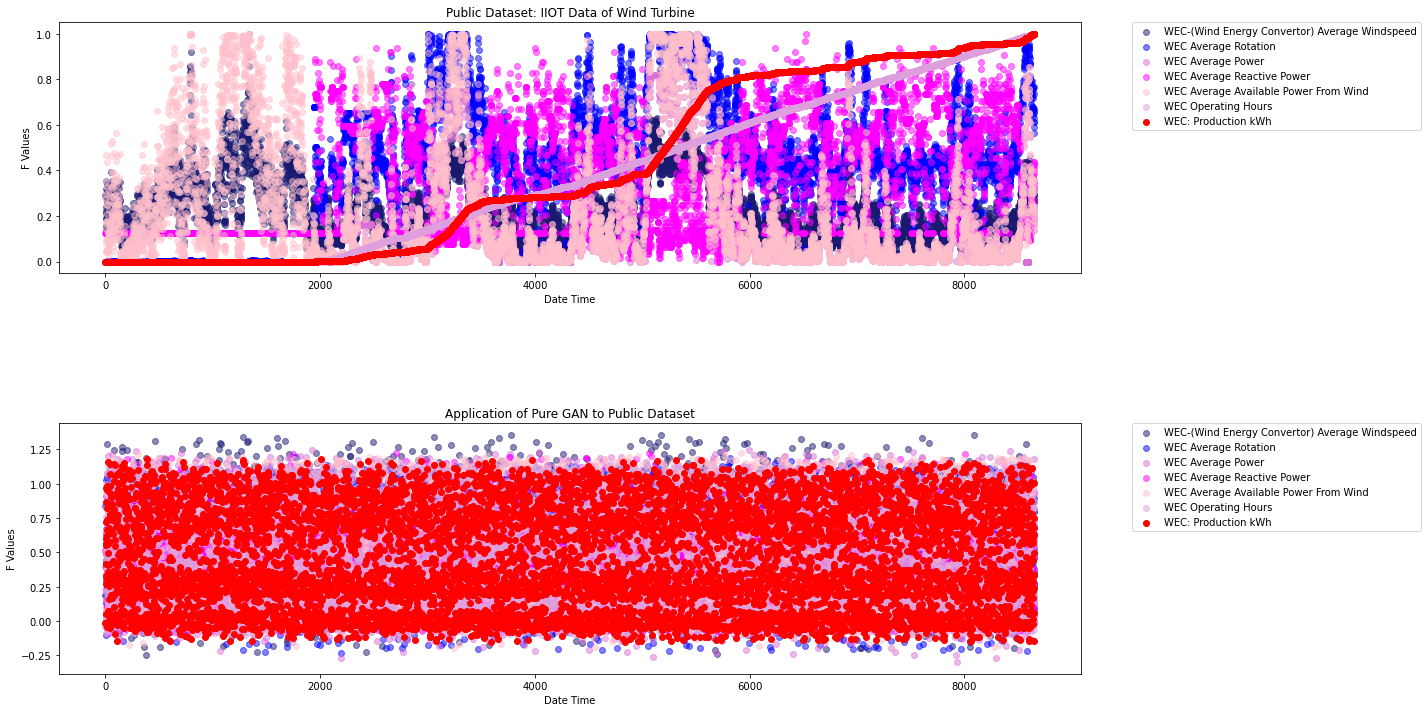

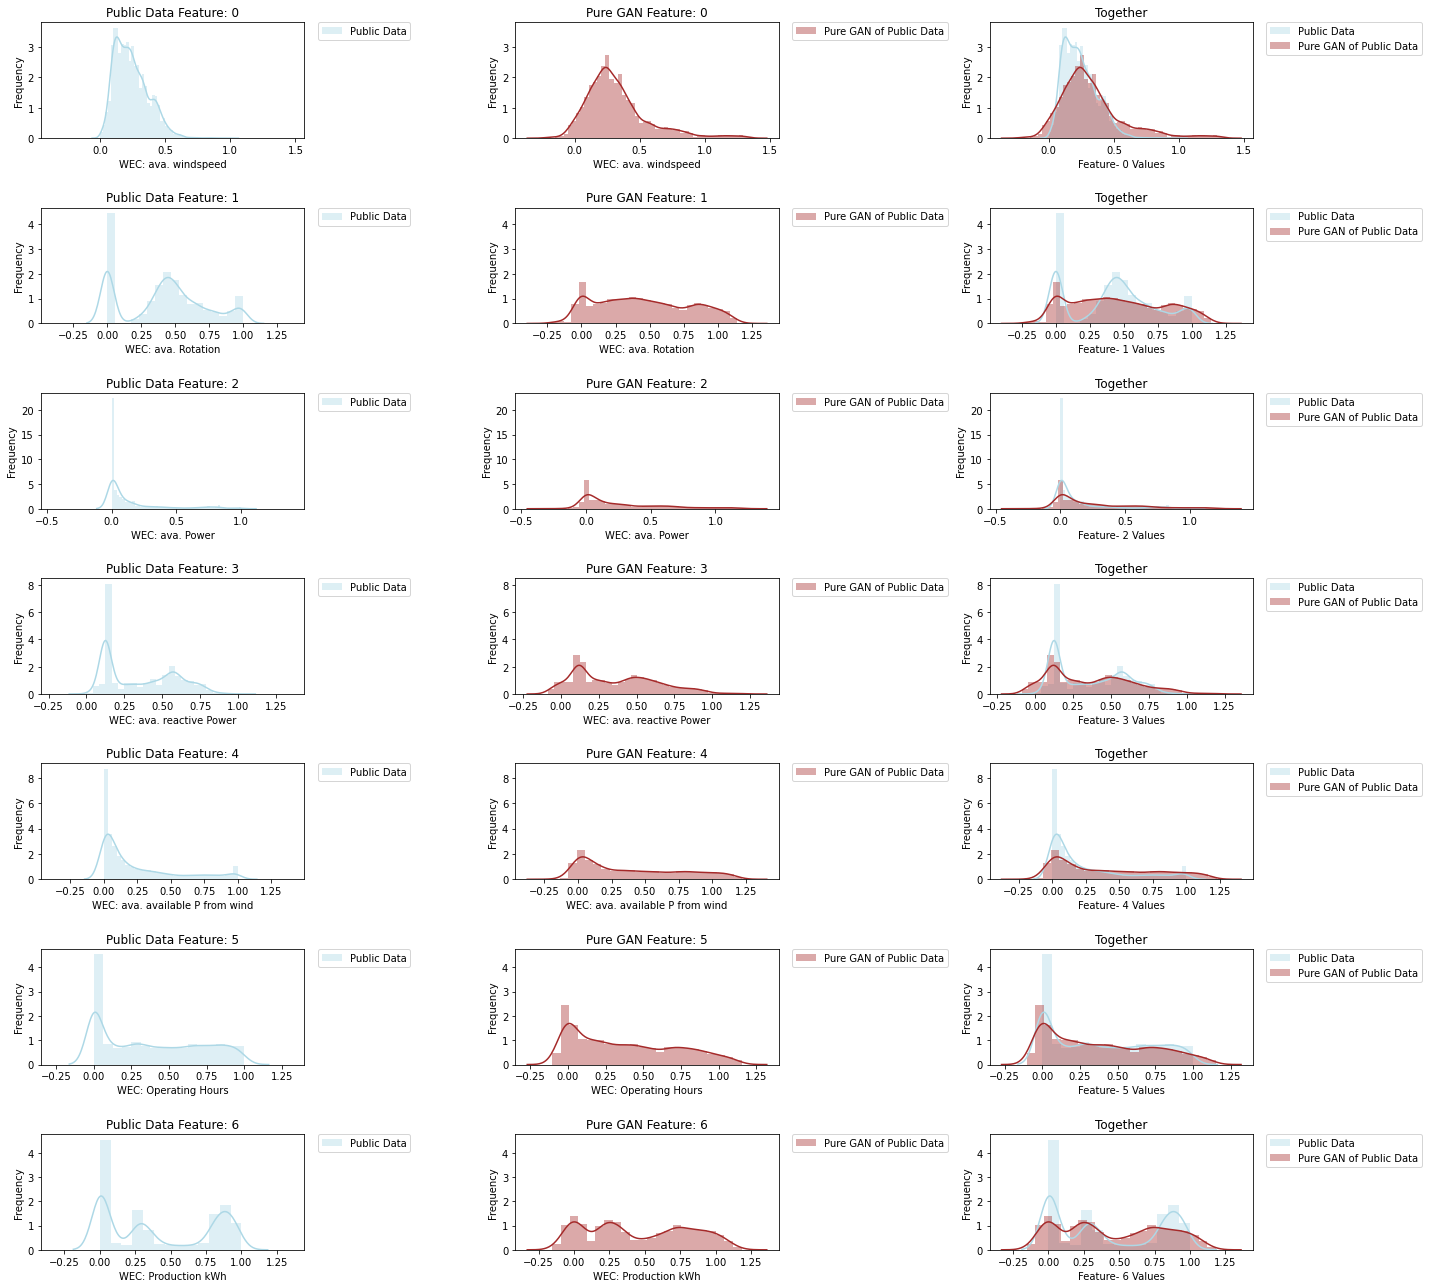

In [7]:
#The Toy Data and Features vs GAN
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.set_title('Mean Values of Public Dataset') 
Xnew = Toy_data.columns 
plt.bar(Xnew, Toy_data.mean().round(2), color = 'cornflowerblue')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('The Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax2 = plt.subplot(3, 3, 2)
ax2.set_title('Mean Values of Public Dataset GAN version') 
Xnew = Toy_data_GAN.columns 
plt.bar(Xnew, Toy_data_GAN.mean().round(2), color = 'orangered')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('Application of Pure GAN to the Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax3 = plt.subplot(3, 3, 3)
ax3.set_title('Pure GAN vs Public dataset') 
x = np.arange(Toy_data.shape[1]) 
width = 0.34
plt.bar(x - width/2, Toy_data.mean(), width, color = 'cornflowerblue', label='The Public Dataset')
plt.bar(x + width/2, Toy_data_GAN.mean(), width, color = 'orangered', label='The Pure GAN Dataset')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.xticks(x, Toy_data.columns, rotation=90)
plt.title('The Public vs the Pure GAN')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1.autoscale()
ax2.autoscale()
ax3.autoscale()

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.4) 
plt.show();

#The Toy Data and Features vs GAN
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 1, 1)
ax1.set_title('Public Dataset: IIOT Data of Wind Turbine') 
Xnew=np.arange(Toy_data.shape[0])
plt.scatter(Xnew, Toy_data['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_data['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: Operating Hours'], label = 'WEC Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax2 = plt.subplot(2, 1, 2)
ax2.set_title('Application of Pure GAN to Public Dataset') 
Xnew=np.arange(Toy_data_GAN.shape[0])
plt.scatter(Xnew, Toy_data_GAN['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_data_GAN['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_data_GAN['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_data_GAN['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_data_GAN['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_data_GAN['WEC: Operating Hours'], label = 'WEC Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_data_GAN['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 

#ax1.get_shared_x_axes().join(ax1, ax2)
#ax1.get_shared_y_axes().join(ax1, ax2)
#ax1.autoscale()
#ax2.autoscale()
plt.show();

#The ToyData vs GAN Comparision 
simplefilter(action='ignore')
fig = plt.figure(figsize=(20, 18))

plot_number = 1
for i in np.arange(0,Toy_data.shape[1],1): 
    ax1 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax1.set_title('Public Data Feature: %d' % i) 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1    
    ax2 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax2.set_title('Pure GAN Feature: %d' % i) 
    sns.distplot(Toy_data_GAN.iloc[:,i], kde=True, color='brown', label ='Pure GAN of Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax3 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax3.set_title('Together') 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    sns.distplot(Toy_data_GAN.iloc[:,i], kde=True, color='brown', label ='Pure GAN of Public Data')
    plt.xlabel('Feature- %d Values' % i) 
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.get_shared_y_axes().join(ax1, ax2, ax3)
    ax1.autoscale()
    ax2.autoscale()
    ax3.autoscale()
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 
plt.show();



Xtoy_train_GAN.shape: (6924, 6) ; ytoy_train_GAN.shape: (6924, 1) ; Xtoy_test_GAN.shape: (1731, 6) ; ytoy_test_GAN.shape: (1731, 1)
intercept_GAN [0.47180699] coefficients_GAN [[-0.03784625 -0.04795343  0.03257404  0.01546179  0.0104547   0.00126466]] coefftoy_GAN.shape (1, 6) R-Squared score GAN of Public Dataset: 0.00041289772231645205 mean_absolute_error: 0.3274052859729886


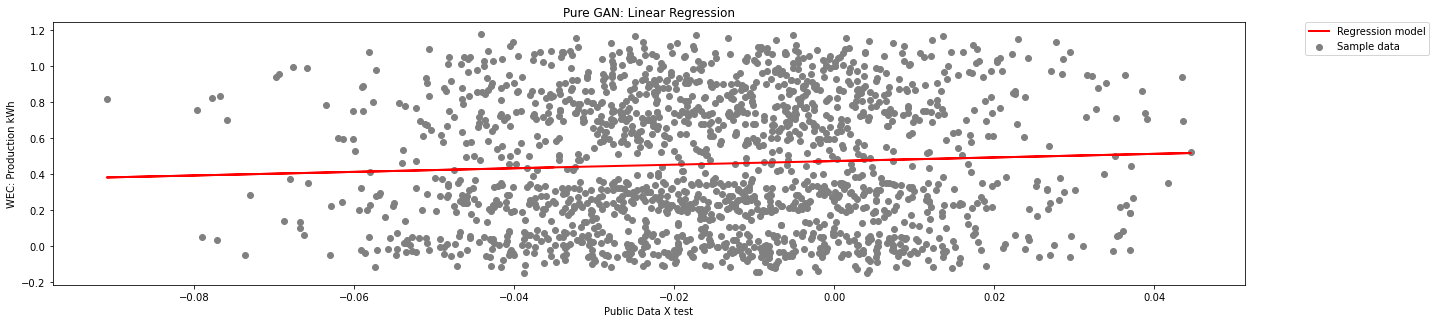

In [8]:
#Linear Regression GAN
ytoy_GAN = Toy_data_GAN[['WEC: Production kWh']]
Xtoy_GAN = Toy_data_GAN[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours']]
Xtoy_train_GAN, Xtoy_test_GAN, ytoy_train_GAN, ytoy_test_GAN = train_test_split(Xtoy_GAN, ytoy_GAN, test_size=0.2, random_state=0)
print('Xtoy_train_GAN.shape:', Xtoy_train_GAN.shape, '; ytoy_train_GAN.shape:', ytoy_train_GAN.shape, 
      '; Xtoy_test_GAN.shape:', Xtoy_test_GAN.shape, '; ytoy_test_GAN.shape:', ytoy_test_GAN.shape)

#Linear Regression for Toy Dataset GAN
lin_regtoy_GAN = LinearRegression()  
reg_modeltoy_GAN = lin_regtoy_GAN.fit(Xtoy_train_GAN, ytoy_train_GAN)
intercepttoy_GAN = lin_regtoy_GAN.intercept_
coefftoy_GAN = lin_regtoy_GAN.coef_
ytoy_pred_GAN = lin_regtoy_GAN.predict(Xtoy_test_GAN)
r2scoretoy_GAN = reg_modeltoy_GAN.score(Xtoy_test_GAN, ytoy_test_GAN)
#accuracytoy_GAN = reg_modeltoy_GAN.score(Xtoy_test_GAN, ytoy_test_GAN)
MAEtoy_GAN = mean_absolute_error(ytoy_test_GAN, ytoy_pred_GAN)
print('intercept_GAN', intercepttoy_GAN, 
      'coefficients_GAN', coefftoy_GAN, 
      'coefftoy_GAN.shape', coefftoy_GAN.shape,
      'R-Squared score GAN of Public Dataset:', r2scoretoy_GAN,
      'mean_absolute_error:',MAEtoy_GAN)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Pure GAN: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('WEC: Production kWh')
plt.scatter(Xtoy_test_GAN.dot(coefftoy_GAN.squeeze()), ytoy_test_GAN, label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_GAN.dot(coefftoy_GAN.squeeze()), ytoy_pred_GAN, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 
plt.show();

### DP Calculations

In [9]:
def DP_Laplace(df_input, epsilon=1):
    df_input_mean = df_input.mean()
    df_DP = df_input.copy()
    for i in np.arange(0,df_input.shape[0],1):
        df_DP.iloc[i] += list(np.random.laplace(df_input_mean, abs(epsilon), 1)) if (np.random.rand()>=0.5) else 0                                                                      
    return df_DP

In [10]:
#DP Dataset
epsilon =0.001
Toy_data_DP = pd.DataFrame(np.zeros(Toy_data.shape))
Toy_data_copy = Toy_data.copy()

for i in range(Toy_data.shape[1]):
    Toy_data_DP.iloc[:,i] = round(DP_Laplace(Toy_data_copy.iloc[:,i], epsilon),4)

Toy_data_DP.columns=[ 'WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
                                'WEC: ava. reactive Power', 'WEC: ava. available P from wind',
                                'WEC: Production kWh','WEC: Operating Hours']      
Toy_data_DP

WEC: ava. windspeed  WEC: ava. Rotation  WEC: ava. Power  \
0                  0.2911              0.4146           0.1464   
1                  0.2236              0.4151           0.1451   
2                  0.4516              0.0000           0.0000   
3                  0.1857              0.0000           0.1456   
4                  0.2405              0.4154           0.1416   
...                   ...                 ...              ...   
8650               0.2616              1.0067           0.1606   
8651               0.2405              0.9834           0.1365   
8652               0.2616              1.0263           0.3239   
8653               0.5122              0.6318           0.1993   
8654               0.5373              0.6630           0.3752   

      WEC: ava. reactive Power  WEC: ava. available P from wind  \
0                       0.4795                           0.5159   
1                       0.4816                           0.1443   
2                       0.4827                           0.1710   
3                       0.1250                           0.3233   
4                       0.1250                           0.4202   
...                        ...                              ...   
8650                    0.4219                           0.1612   
8651                    0.4375                           0.1368   
8652                    0.7952                           0.1775   
8653                    0.7788                           0.2000   
8654                    0.3906                           0.4713   

      WEC: Production kWh  WEC: Operating Hours  
0                  0.3823                0.4146  
1                  0.3811                0.0000  
2                  0.0000                0.4162  
3                  0.0000                0.0000  
4                  0.3838                0.0000  
...                   ...                   ...  
8650               1.3824                0.9994  
8651               1.0000                0.9995  
8652               1.3822                0.9997  
8653               1.3818                0.9998  
8654               1.0000                1.4162  

[8655 rows x 7 columns]

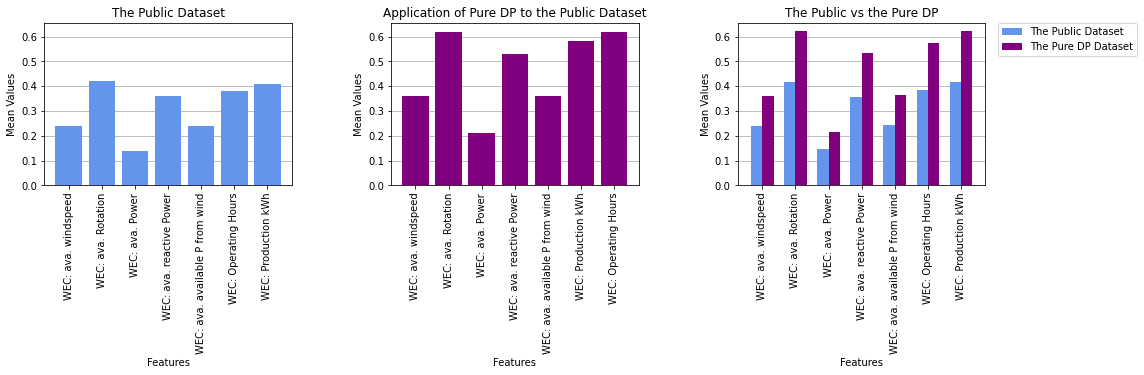

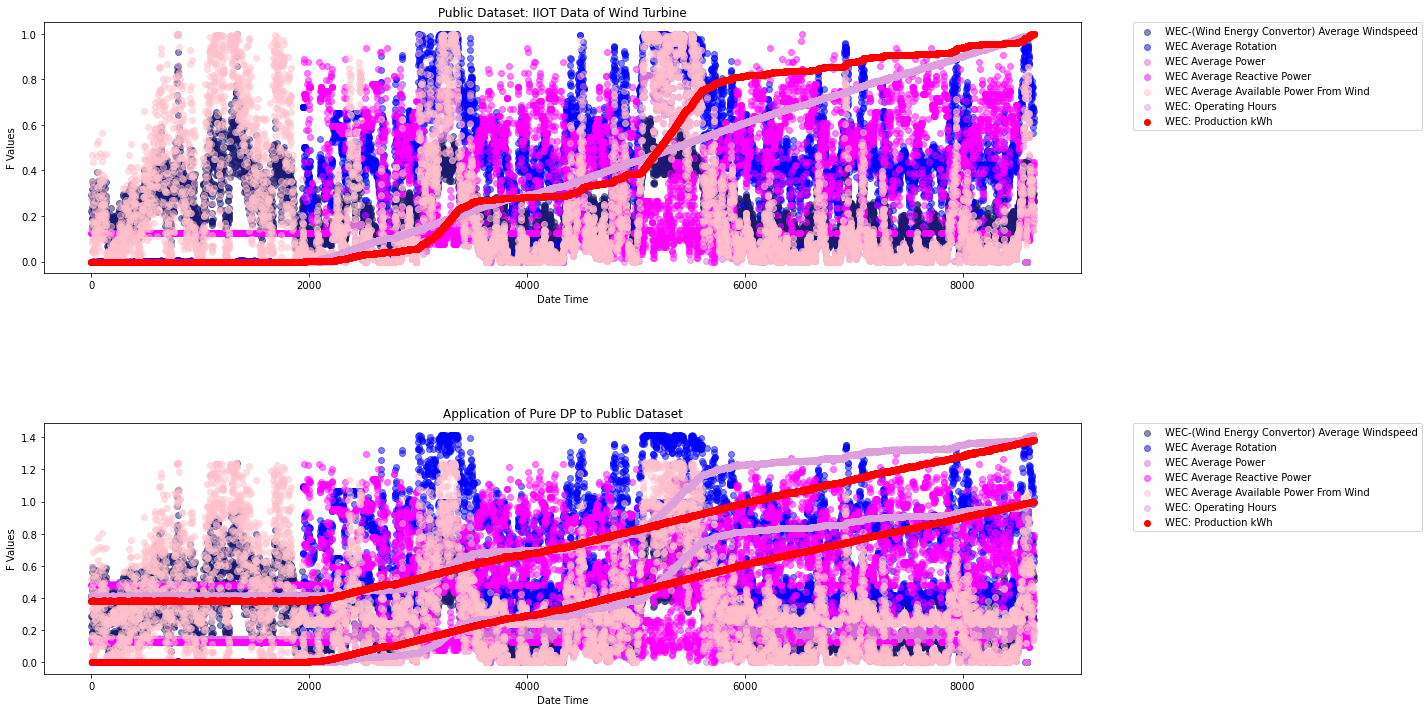

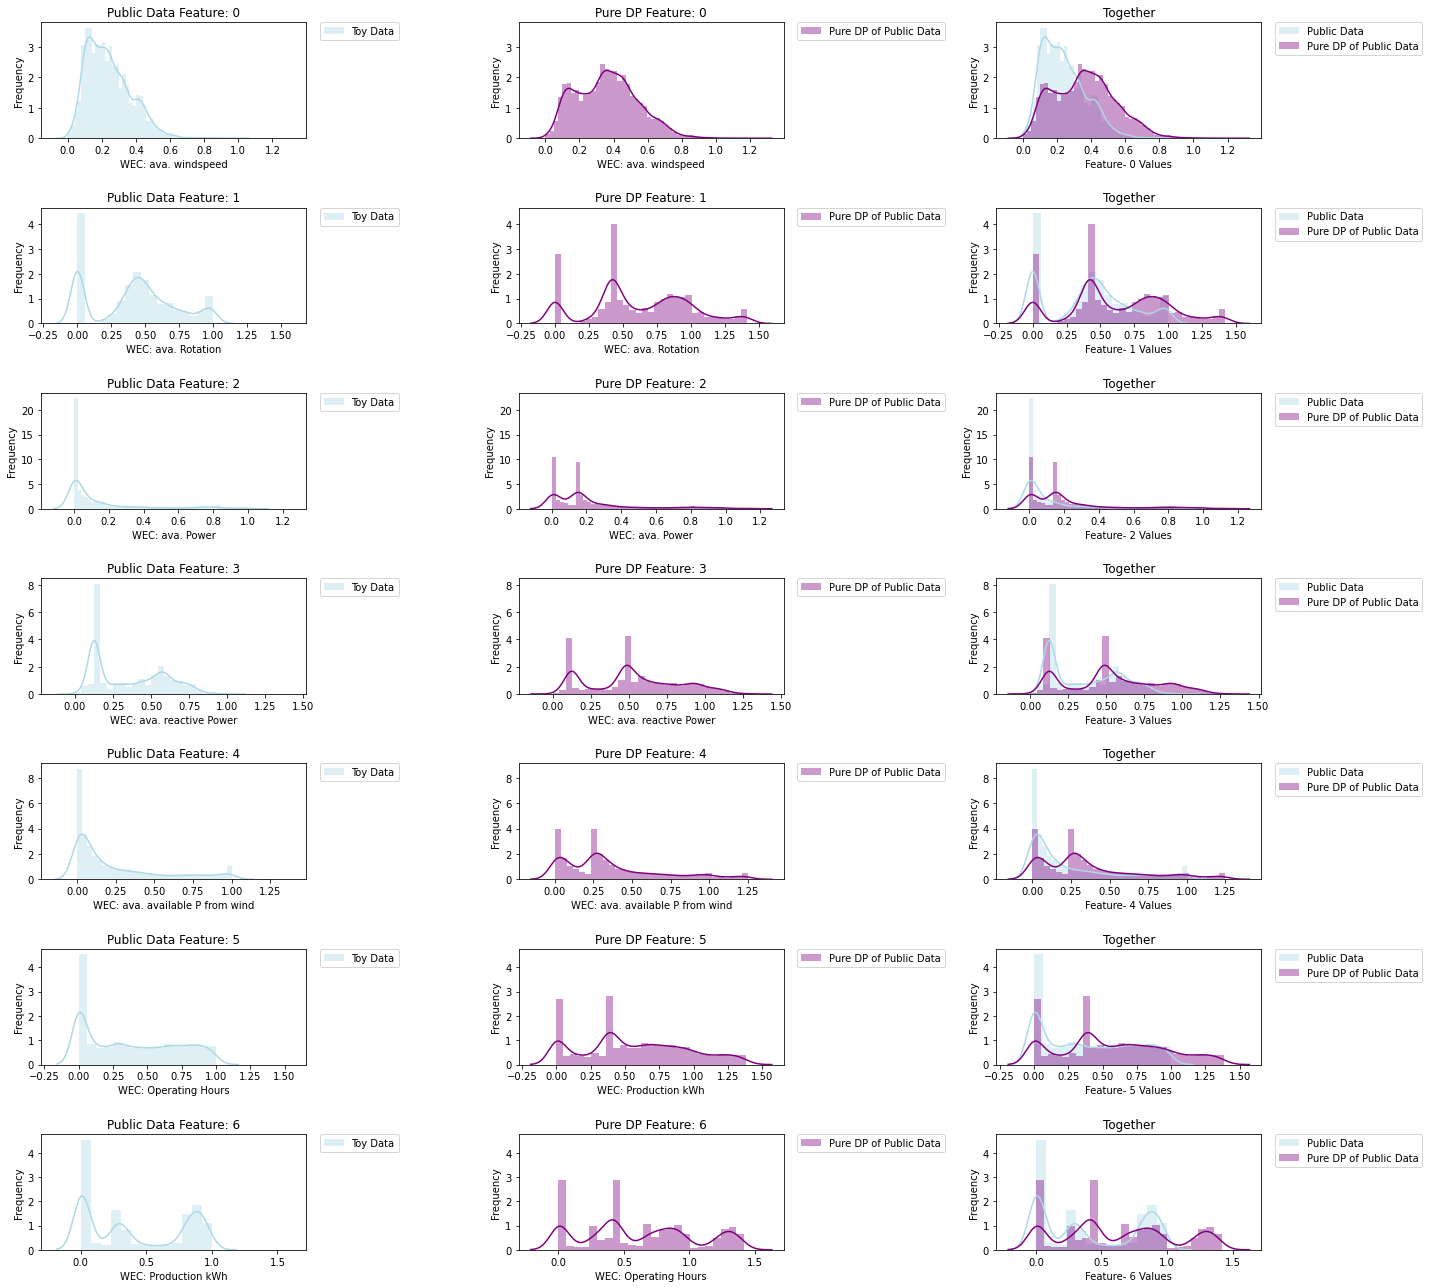

In [11]:
#The Toy Data and Features vs DP
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.set_title('Mean Values of Public Dataset') 
Xnew = Toy_data.columns 
plt.bar(Xnew, Toy_data.mean().round(2), color = 'cornflowerblue')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('The Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax2 = plt.subplot(3, 3, 2)
ax2.set_title('Mean Values of Public Dataset DP version') 
Xnew = Toy_data_DP.columns 
plt.bar(Xnew, Toy_data_DP.mean().round(2), color = 'purple')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('Application of Pure DP to the Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax3 = plt.subplot(3, 3, 3)
ax3.set_title('Pure DP vs Public dataset') 
x = np.arange(Toy_data.shape[1]) 
width = 0.34
plt.bar(x - width/2, Toy_data.mean(), width, color = 'cornflowerblue', label='The Public Dataset')
plt.bar(x + width/2, Toy_data_DP.mean(), width, color = 'purple', label='The Pure DP Dataset')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.xticks(x, Toy_data.columns, rotation=90)
plt.title('The Public vs the Pure DP')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1.autoscale()
ax2.autoscale()
ax3.autoscale()

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.4) 
plt.show();

#The Toy Data and Features vs DP
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 1, 1)
ax1.set_title('Public Dataset: IIOT Data of Wind Turbine') 
Xnew=np.arange(Toy_data.shape[0])
plt.scatter(Xnew, Toy_data['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_data['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: Operating Hours'], label = 'WEC: Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_data['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax2 = plt.subplot(2, 1, 2)
ax2.set_title('Application of Pure DP to Public Dataset') 
Xnew=np.arange(Toy_data_DP.shape[0])
plt.scatter(Xnew, Toy_data_DP['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_data_DP['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_data_DP['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_data_DP['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_data_DP['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_data_DP['WEC: Operating Hours'], label = 'WEC: Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_data_DP['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 

#ax1.get_shared_x_axes().join(ax1, ax2)
#ax1.get_shared_y_axes().join(ax1, ax2)
#ax1.autoscale()
#ax2.autoscale()
plt.show();

#The ToyData vs DP Comparision 
simplefilter(action='ignore')
fig = plt.figure(figsize=(20, 18))

plot_number = 1
for i in np.arange(0,Toy_data.shape[1],1): 
    ax1 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax1.set_title('Public Data Feature: %d' % i) 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Toy Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1    
    ax2 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax2.set_title('Pure DP Feature: %d' % i) 
    sns.distplot(Toy_data_DP.iloc[:,i], kde=True, color='purple', label ='Pure DP of Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax3 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax3.set_title('Together') 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    sns.distplot(Toy_data_DP.iloc[:,i], kde=True, color='purple', label ='Pure DP of Public Data')
    plt.xlabel('Feature- %d Values' % i) 
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.get_shared_y_axes().join(ax1, ax2, ax3)
    ax1.autoscale()
    ax2.autoscale()
    ax3.autoscale()
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 
plt.show();



Xtoy_train_DP.shape: (6924, 6) ; ytoy_train_DP.shape: (6924, 1) ; Xtoy_test_DP.shape: (1731, 6) ; ytoy_test_DP.shape: (1731, 1)
intercept_DP [0.16415479] coefficients_DP [[-0.10715898  0.07642797  0.08670652  0.06756967 -0.08368594  0.60752356]] coefftoy_DP.shape (1, 6) R-Squared score DP of Public Dataset: 0.5791900610123626 mean_absolute_error: 0.2046071215880455


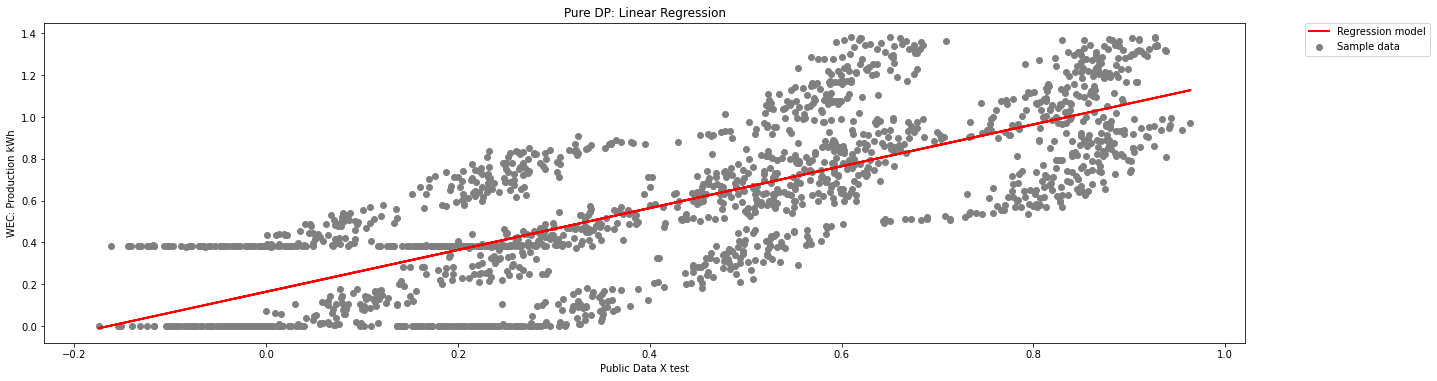

In [12]:
#Linear Regression DP
ytoy_DP = Toy_data_DP[['WEC: Production kWh']]
Xtoy_DP = Toy_data_DP[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours']]
Xtoy_train_DP, Xtoy_test_DP, ytoy_train_DP, ytoy_test_DP = train_test_split(Xtoy_DP, ytoy_DP, test_size=0.2, random_state=0)
print('Xtoy_train_DP.shape:', Xtoy_train_DP.shape, '; ytoy_train_DP.shape:', ytoy_train_DP.shape, 
      '; Xtoy_test_DP.shape:', Xtoy_test_DP.shape, '; ytoy_test_DP.shape:', ytoy_test_DP.shape)

#Linear Regression for Toy Dataset DP
lin_regtoy_DP = LinearRegression()  
reg_modeltoy_DP = lin_regtoy_DP.fit(Xtoy_train_DP, ytoy_train_DP)
intercepttoy_DP = lin_regtoy_DP.intercept_
coefftoy_DP = lin_regtoy_DP.coef_
ytoy_pred_DP = lin_regtoy_DP.predict(Xtoy_test_DP)
r2scoretoy_DP = reg_modeltoy_DP.score(Xtoy_test_DP, ytoy_test_DP)
#accuracytoy_DP = reg_modeltoy_DP.score(Xtoy_test_DP, ytoy_test_DP)
MAEtoy_DP = mean_absolute_error(ytoy_test_DP, ytoy_pred_DP)
print('intercept_DP', intercepttoy_DP, 
      'coefficients_DP', coefftoy_DP, 
      'coefftoy_DP.shape', coefftoy_DP.shape,
      'R-Squared score DP of Public Dataset:', r2scoretoy_DP,
      'mean_absolute_error:', MAEtoy_DP)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Pure DP: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('WEC: Production kWh')
plt.scatter(Xtoy_test_DP.dot(coefftoy_DP.squeeze()), ytoy_test_DP, label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_DP.dot(coefftoy_DP.squeeze()), ytoy_pred_DP, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

## IIOT Privacy Models

#### MODEL 0C (Only One Feature : GAN + DP) : MODEL A

In [13]:
# 0:'WEC: ava. windspeed', 1:'WEC: ava. Rotation', 
# 2:'WEC: ava. Power', 3:'WEC: ava. reactive Power', 4:'WEC: ava. available P from wind', 5:'WEC: Production kWh'
Toy_model_0C = pd.concat( [Toy_data[['WEC: ava. windspeed','WEC: ava. Rotation']].reset_index(),
                          Toy_data_GAN[['WEC: ava. Power']].reset_index(),
                          Toy_data[['WEC: ava. reactive Power','WEC: ava. available P from wind',
                          'WEC: Operating Hours','WEC: Production kWh']].reset_index()], axis=1)
del Toy_model_0C['index']

epsilon =0.001
Toy_model_0C_copy = Toy_model_0C.copy()
Toy_model_0C[['WEC: ava. Power']] = round(DP_Laplace(Toy_model_0C_copy[['WEC: ava. Power']], epsilon),4)
Toy_model_0C

WEC: ava. windspeed  WEC: ava. Rotation  WEC: ava. Power  \
0                0.291139            0.000000           0.3930   
1                0.223629            0.000000           0.3246   
2                0.210970            0.000000           0.4952   
3                0.185654            0.000000           0.3291   
4                0.240506            0.000000           0.4880   
...                   ...                 ...              ...   
8650             0.261603            0.591712           1.1271   
8651             0.240506            0.566576           0.7289   
8652             0.261603            0.610734          -0.0093   
8653             0.270042            0.631793           1.1801   
8654             0.295359            0.663043           0.3787   

      WEC: ava. reactive Power  WEC: ava. available P from wind  \
0                     0.125000                         0.272964   
1                     0.125000                         0.144300   
2                     0.125000                         0.171010   
3                     0.125000                         0.081433   
4                     0.125000                         0.178827   
...                        ...                              ...   
8650                  0.421875                         0.161238   
8651                  0.437500                         0.136808   
8652                  0.437500                         0.177524   
8653                  0.421875                         0.200000   
8654                  0.390625                         0.228990   

      WEC: Operating Hours  WEC: Production kWh  
0                      0.0             0.000000  
1                      0.0             0.000000  
2                      0.0             0.000000  
3                      0.0             0.000000  
4                      0.0             0.000000  
...                    ...                  ...  
8650                   1.0             0.999415  
8651                   1.0             0.999523  
8652                   1.0             0.999662  
8653                   1.0             0.999819  
8654                   1.0             1.000000  

[8655 rows x 7 columns]

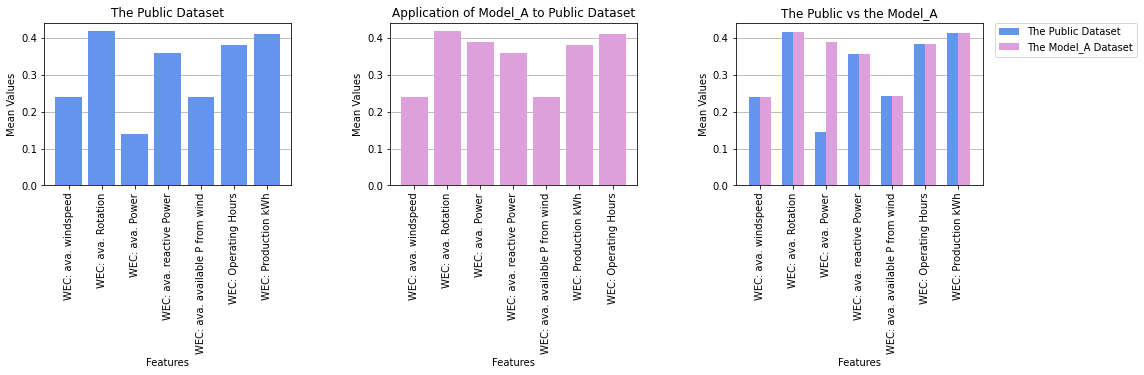

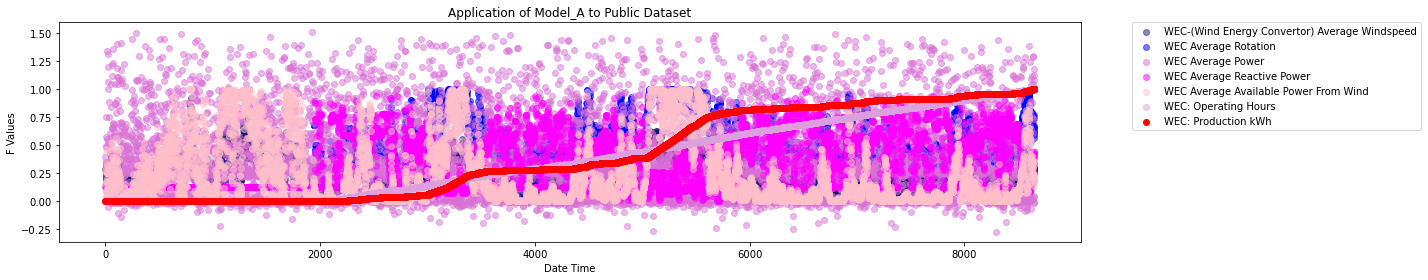

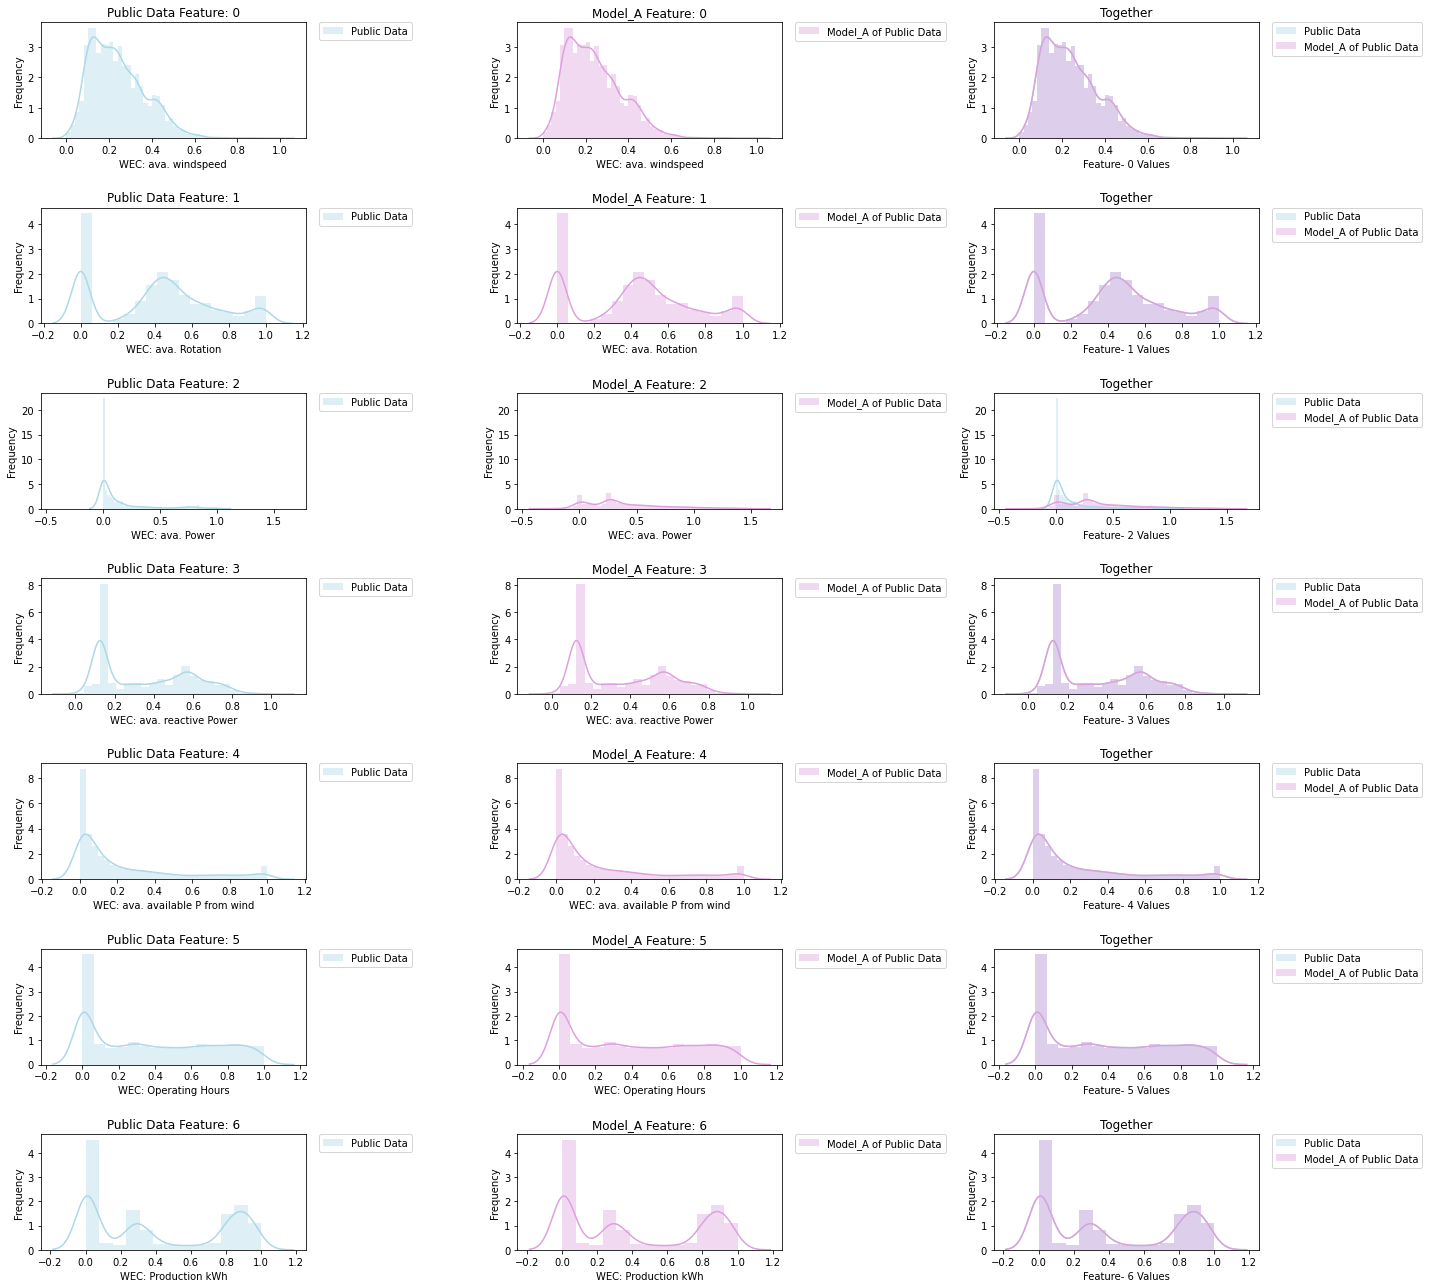

In [14]:
#The Toy Data and Features vs Model_0C
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.set_title('Mean Values of Public Dataset') 
Xnew = Toy_data.columns 
plt.bar(Xnew, Toy_data.mean().round(2), color = 'cornflowerblue')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('The Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax2 = plt.subplot(3, 3, 2)
ax2.set_title('Mean Values of Public Dataset Model_A version') 
Xnew = Toy_data_DP.columns 
plt.bar(Xnew, Toy_model_0C.mean().round(2), color = 'plum')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('Application of Model_A to Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax3 = plt.subplot(3, 3, 3)
ax3.set_title('Model_A vs Public dataset') 
x = np.arange(Toy_data.shape[1]) 
width = 0.34
plt.bar(x - width/2, Toy_data.mean(), width, color = 'cornflowerblue', label='The Public Dataset')
plt.bar(x + width/2, Toy_model_0C.mean(), width, color = 'plum', label='The Model_A Dataset')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.xticks(x, Toy_data.columns, rotation=90)
plt.title('The Public vs the Model_A')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1.autoscale()
ax2.autoscale()
ax3.autoscale()

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.4) 
plt.show();

#scatter
fig = plt.figure(figsize=(20, 4))
ax4 = plt.subplot()
ax4.set_title('Application of Model_A to Public Dataset') 
Xnew=np.arange(Toy_model_0C.shape[0])
plt.scatter(Xnew, Toy_model_0C['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_model_0C['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_model_0C['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_model_0C['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_model_0C['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_model_0C['WEC: Operating Hours'], label = 'WEC: Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_model_0C['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 


#Comparision 
simplefilter(action='ignore')
fig = plt.figure(figsize=(20, 18))

plot_number = 1
for i in np.arange(0,Toy_data.shape[1],1): 
    ax1 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax1.set_title('Public Data Feature: %d' % i) 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1    
    ax2 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax2.set_title('Model_A Feature: %d' % i) 
    sns.distplot(Toy_model_0C.iloc[:,i], kde=True, color='plum', label ='Model_A of Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax3 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax3.set_title('Together') 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    sns.distplot(Toy_model_0C.iloc[:,i], kde=True, color='plum', label ='Model_A of Public Data')
    plt.xlabel('Feature- %d Values' % i) 
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.get_shared_y_axes().join(ax1, ax2, ax3)
    ax1.autoscale()
    ax2.autoscale()
    ax3.autoscale()
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 
plt.show();


Xtoy_train_model_0C.shape: (6924, 6) ; ytoy_train_model_0C.shape: (6924, 1) ; Xtoy_test_model_0C.shape: (1731, 6) ; ytoy_test_model_0C.shape: (1731, 1)
intercept_model_0C [-0.02956457] coefficients_model_0C [[ 9.63745659e-02 -2.42635319e-02  1.00904917e-03 -7.80110483e-03
  -1.48670411e-02  1.13988459e+00]] coefftoy_model_0C.shape (1, 6) R-Squared score model_0C of Public Dataset: 0.9685016595519783 mean_absolute_error: 0.05075028812242784


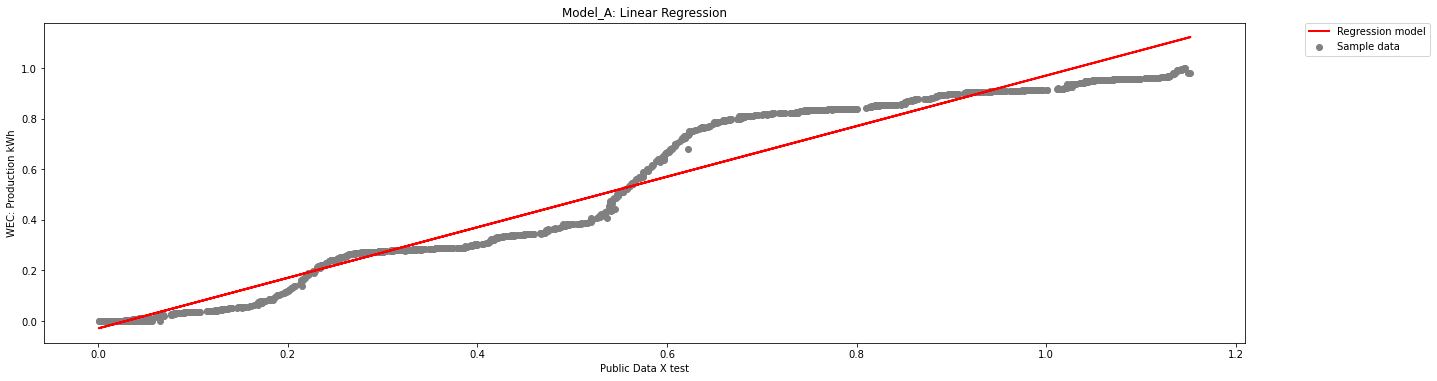

In [15]:
#Linear Regression model_0C 
ytoy_model_0C = Toy_model_0C[['WEC: Production kWh']]
Xtoy_model_0C = Toy_model_0C[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours']]
Xtoy_train_model_0C, Xtoy_test_model_0C, ytoy_train_model_0C, ytoy_test_model_0C = train_test_split(
    Xtoy_model_0C, ytoy_model_0C, test_size=0.2, random_state=0)
print('Xtoy_train_model_0C.shape:', Xtoy_train_model_0C.shape, '; ytoy_train_model_0C.shape:', ytoy_train_model_0C.shape, 
      '; Xtoy_test_model_0C.shape:', Xtoy_test_model_0C.shape, '; ytoy_test_model_0C.shape:', ytoy_test_model_0C.shape)

#Linear Regression for Toy Dataset model_0C
lin_regtoy_model_0C = LinearRegression()  
reg_modeltoy_model_0C = lin_regtoy_model_0C.fit(Xtoy_train_model_0C, ytoy_train_model_0C)
intercepttoy_model_0C = lin_regtoy_model_0C.intercept_
coefftoy_model_0C = lin_regtoy_model_0C.coef_
ytoy_pred_model_0C = lin_regtoy_model_0C.predict(Xtoy_test_model_0C)
r2scoretoy_model_0C = reg_modeltoy_model_0C.score(Xtoy_test_model_0C, ytoy_test_model_0C)
#accuracytoy_model_0C = reg_modeltoy_model_0C.score(Xtoy_test_model_0C, ytoy_test_model_0C)
MAEtoy_model_0C = mean_absolute_error(ytoy_test_model_0C, ytoy_pred_model_0C)

print('intercept_model_0C', intercepttoy_model_0C, 
      'coefficients_model_0C', coefftoy_model_0C, 
      'coefftoy_model_0C.shape', coefftoy_model_0C.shape,
      'R-Squared score model_0C of Public Dataset:', r2scoretoy_model_0C,
      'mean_absolute_error:', MAEtoy_model_0C)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Model_A: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('WEC: Production kWh')
plt.scatter(Xtoy_test_model_0C.dot(coefftoy_model_0C.squeeze()), ytoy_test_model_0C, 
            label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_model_0C.dot(coefftoy_model_0C.squeeze()), ytoy_pred_model_0C, 
         label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

#### MODEL 2C (Two Features: GAN + DP) : MODEL B

In [16]:
# 0:'WEC: ava. windspeed', 1:'WEC: ava. Rotation', 
# 2:'WEC: ava. Power', 3:'WEC: ava. reactive Power', 4:'WEC: ava. available P from wind', 5:'WEC: Production kWh'
Toy_model_2C = pd.concat( [Toy_data[['WEC: ava. windspeed','WEC: ava. Rotation']].reset_index(),
                          Toy_data_GAN[['WEC: ava. Power','WEC: ava. reactive Power']].reset_index(),
                          Toy_data[['WEC: ava. available P from wind',
                          'WEC: Operating Hours','WEC: Production kWh']].reset_index()], axis=1)
del Toy_model_2C['index']

epsilon =0.001
Toy_model_2C_copy = Toy_model_2C.copy()

Toy_model_2C[['WEC: ava. Power']] = round(DP_Laplace(Toy_model_2C_copy[['WEC: ava. Power']], epsilon),4)
Toy_model_2C[['WEC: ava. reactive Power']] = round(DP_Laplace(Toy_model_2C_copy[['WEC: ava. reactive Power']], epsilon),4)

Toy_model_2C

WEC: ava. windspeed  WEC: ava. Rotation  WEC: ava. Power  \
0                0.291139            0.000000           0.3930   
1                0.223629            0.000000           0.3212   
2                0.210970            0.000000           0.7557   
3                0.185654            0.000000           0.0692   
4                0.240506            0.000000           0.4880   
...                   ...                 ...              ...   
8650             0.261603            0.591712           0.8681   
8651             0.240506            0.566576           0.9879   
8652             0.261603            0.610734           0.2509   
8653             0.270042            0.631793           1.4395   
8654             0.295359            0.663043           0.3787   

      WEC: ava. reactive Power  WEC: ava. available P from wind  \
0                       0.8742                         0.272964   
1                       0.3571                         0.144300   
2                       0.9311                         0.171010   
3                       0.3231                         0.081433   
4                       0.5944                         0.178827   
...                        ...                              ...   
8650                    1.2959                         0.161238   
8651                    0.9124                         0.136808   
8652                    0.8285                         0.177524   
8653                    0.0442                         0.200000   
8654                    0.5051                         0.228990   

      WEC: Operating Hours  WEC: Production kWh  
0                      0.0             0.000000  
1                      0.0             0.000000  
2                      0.0             0.000000  
3                      0.0             0.000000  
4                      0.0             0.000000  
...                    ...                  ...  
8650                   1.0             0.999415  
8651                   1.0             0.999523  
8652                   1.0             0.999662  
8653                   1.0             0.999819  
8654                   1.0             1.000000  

[8655 rows x 7 columns]

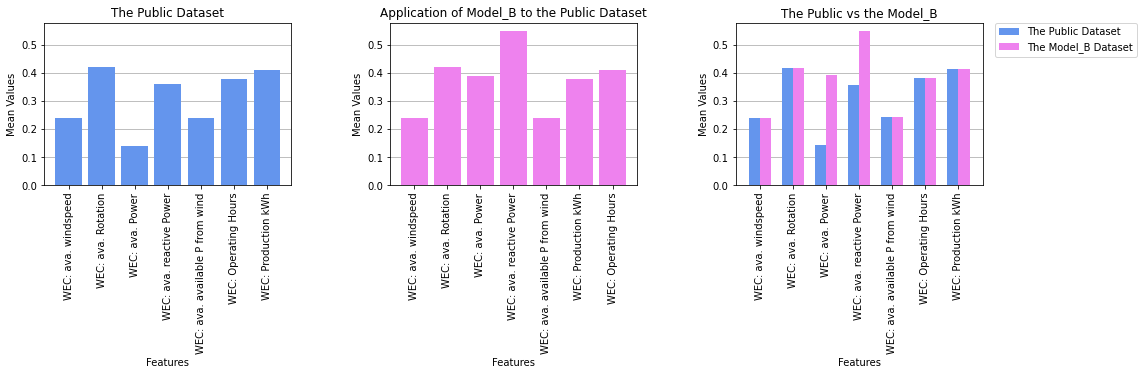

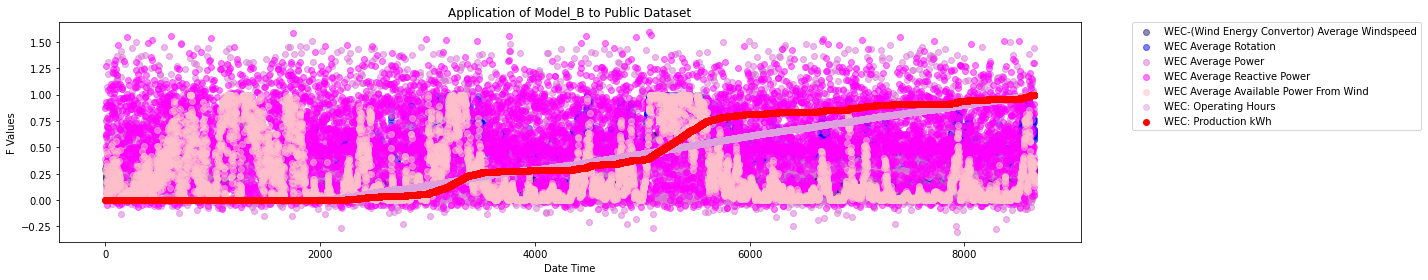

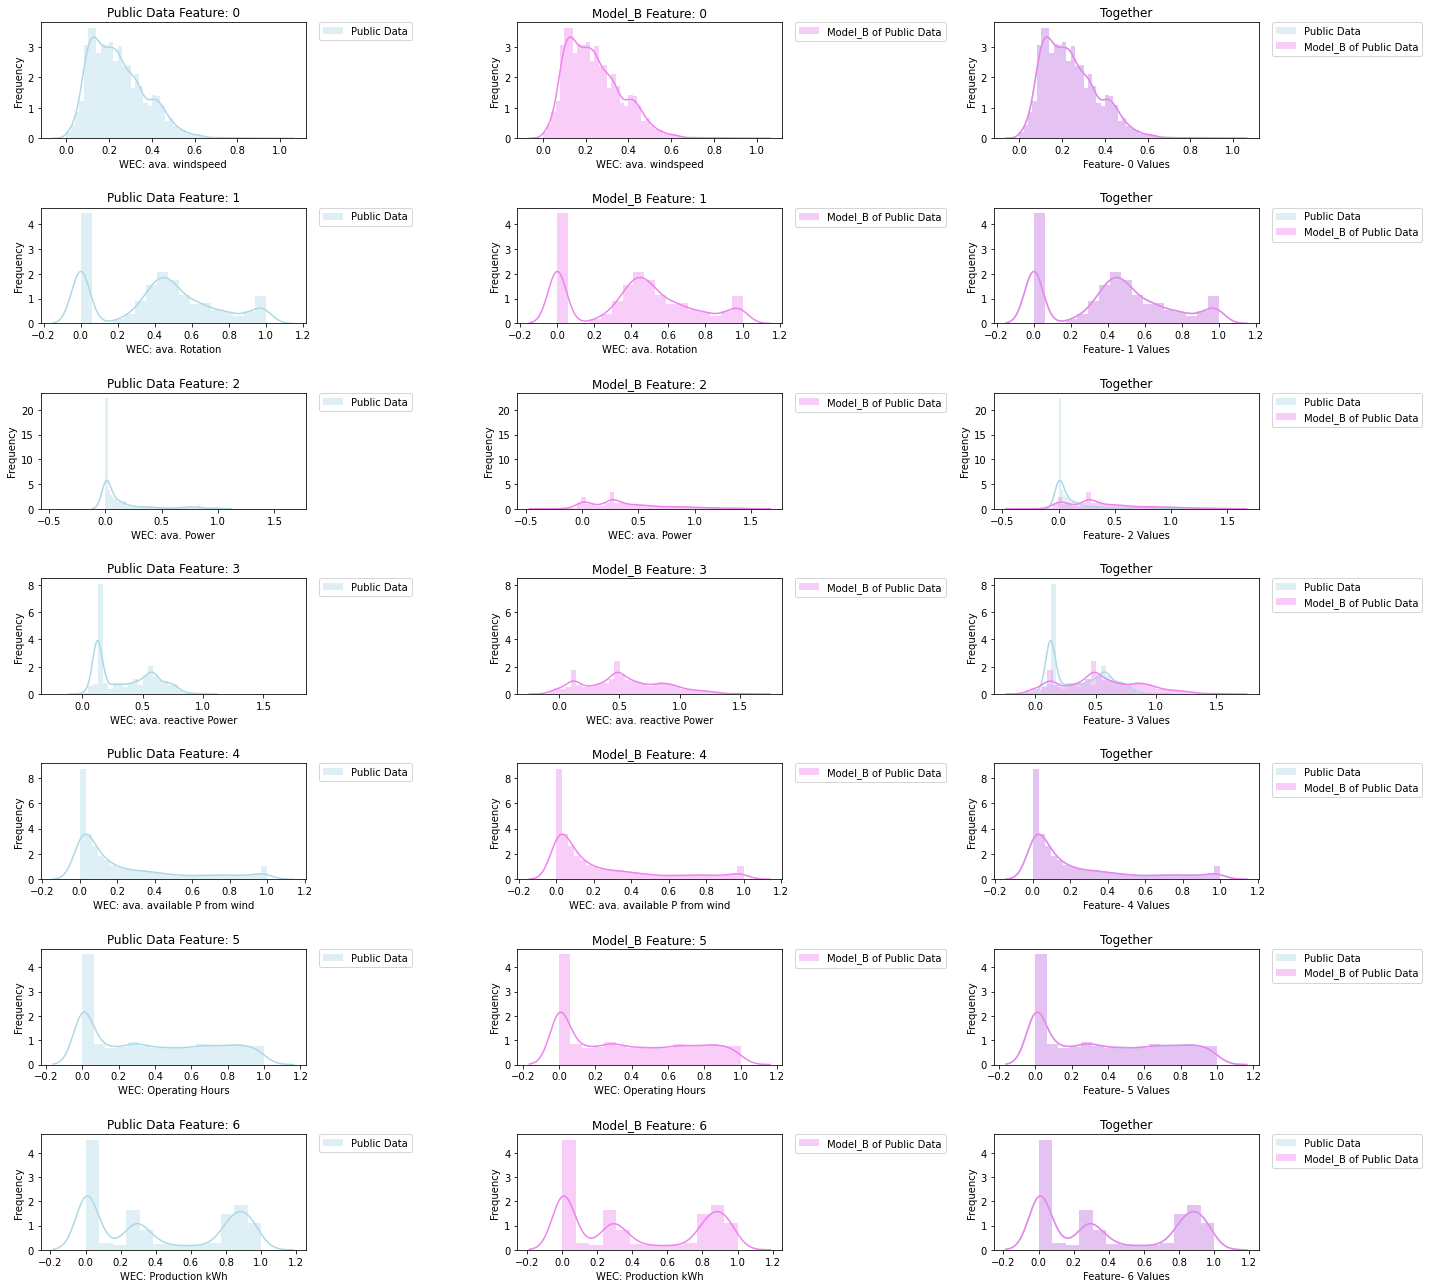

In [17]:
#The Toy Data and Features vs Model_2C
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.set_title('Mean Values of Public Dataset') 
Xnew = Toy_data.columns 
plt.bar(Xnew, Toy_data.mean().round(2), color = 'cornflowerblue')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('The Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax2 = plt.subplot(3, 3, 2)
ax2.set_title('Mean Values of Public Dataset Model_B version') 
Xnew = Toy_data_DP.columns 
plt.bar(Xnew, Toy_model_2C.mean().round(2), color = 'violet')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.title('Application of Model_B to the Public Dataset')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=90)

ax3 = plt.subplot(3, 3, 3)
ax3.set_title('Model_B vs Public dataset') 
x = np.arange(Toy_data.shape[1]) 
width = 0.34
plt.bar(x - width/2, Toy_data.mean(), width, color = 'cornflowerblue', label='The Public Dataset')
plt.bar(x + width/2, Toy_model_2C.mean(), width, color = 'violet', label='The Model_B Dataset')
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.xticks(x, Toy_data.columns, rotation=90)
plt.title('The Public vs the Model_B')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax1.get_shared_x_axes().join(ax1, ax2, ax3)
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1.autoscale()
ax2.autoscale()
ax3.autoscale()

plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.4) 
plt.show();

#scatter
fig = plt.figure(figsize=(20, 4))
ax4 = plt.subplot()
ax4.set_title('Application of Model_B to Public Dataset') 
Xnew=np.arange(Toy_model_2C.shape[0])
plt.scatter(Xnew, Toy_model_2C['WEC: ava. windspeed'], label = 'WEC-(Wind Energy Convertor) Average Windspeed', color='midnightblue', alpha=0.5 )
plt.scatter(Xnew, Toy_model_2C['WEC: ava. Rotation'], label ='WEC Average Rotation', color='blue', alpha=0.5)
plt.scatter(Xnew, Toy_model_2C['WEC: ava. Power'], label = 'WEC Average Power', color='orchid', alpha=0.5)
plt.scatter(Xnew, Toy_model_2C['WEC: ava. reactive Power'], label = 'WEC Average Reactive Power', color='fuchsia', alpha=0.5)
plt.scatter(Xnew, Toy_model_2C['WEC: ava. available P from wind'], label = 'WEC Average Available Power From Wind', color='pink', alpha=0.5)
plt.scatter(Xnew, Toy_model_2C['WEC: Operating Hours'], label = 'WEC: Operating Hours', color='plum', alpha=0.5)
plt.scatter(Xnew, Toy_model_2C['WEC: Production kWh'], label = 'WEC: Production kWh',  color='red')
plt.xlabel('Date Time')
plt.ylabel('F Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 


#Comparision 
simplefilter(action='ignore')
fig = plt.figure(figsize=(20, 18))

plot_number = 1
for i in np.arange(0,Toy_data.shape[1],1): 
    ax1 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax1.set_title('Public Data Feature: %d' % i) 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1    
    ax2 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax2.set_title('Model_B Feature: %d' % i) 
    sns.distplot(Toy_model_2C.iloc[:,i], kde=True, color='violet', label ='Model_B of Public Data')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax3 = plt.subplot(Toy_data.shape[1], 3, plot_number)
    ax3.set_title('Together') 
    sns.distplot(Toy_data.iloc[:,i], kde=True, color='lightblue', label ='Public Data')
    sns.distplot(Toy_model_2C.iloc[:,i], kde=True, color='violet', label ='Model_B of Public Data')
    plt.xlabel('Feature- %d Values' % i) 
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot_number += 1
    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.get_shared_y_axes().join(ax1, ax2, ax3)
    ax1.autoscale()
    ax2.autoscale()
    ax3.autoscale()
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.8) 
plt.show();


Xtoy_train_model_2C.shape: (6924, 6) ; ytoy_train_model_2C.shape: (6924, 1) ; Xtoy_test_model_2C.shape: (1731, 6) ; ytoy_test_model_2C.shape: (1731, 1)
intercept_model_2C [-0.0307408] coefficients_model_2C [[ 0.09160865 -0.02626829  0.00123637 -0.00142546 -0.00924001  1.13908905]] coefftoy_model_2C.shape (1, 6) R-Squared score model_2C of Public Dataset: 0.9685141726717815 mean_absolute_error: 0.050943322180186205


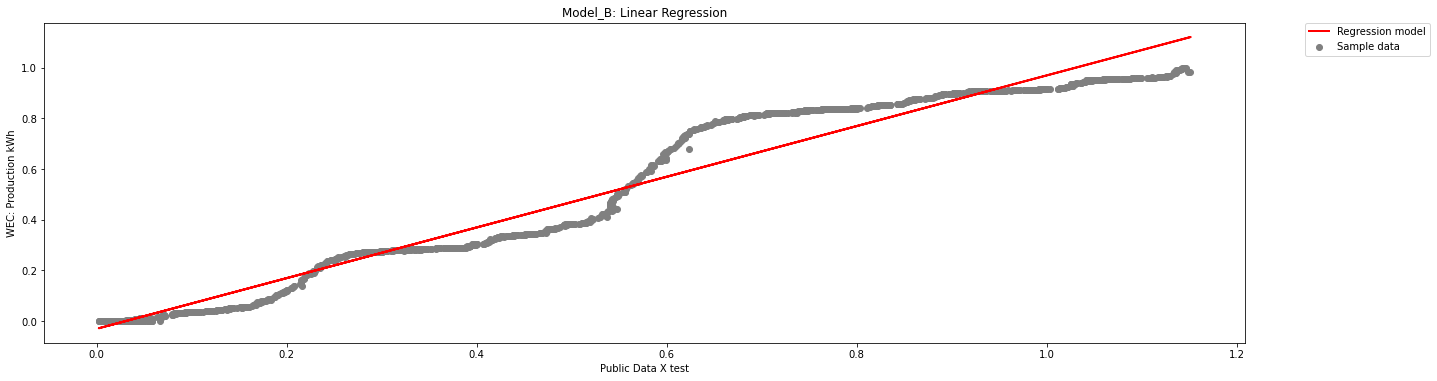

In [18]:
#Linear Regression model_2C
ytoy_model_2C = Toy_model_2C[['WEC: Production kWh']]
Xtoy_model_2C = Toy_model_2C[['WEC: ava. windspeed', 'WEC: ava. Rotation', 'WEC: ava. Power',
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours']]
Xtoy_train_model_2C, Xtoy_test_model_2C, ytoy_train_model_2C, ytoy_test_model_2C = train_test_split(
    Xtoy_model_2C, ytoy_model_2C, test_size=0.2, random_state=0)
print('Xtoy_train_model_2C.shape:', Xtoy_train_model_2C.shape, '; ytoy_train_model_2C.shape:', ytoy_train_model_2C.shape, 
      '; Xtoy_test_model_2C.shape:', Xtoy_test_model_2C.shape, '; ytoy_test_model_2C.shape:', ytoy_test_model_2C.shape)

#Linear Regression for Toy Dataset model_2C
lin_regtoy_model_2C = LinearRegression()  
reg_modeltoy_model_2C = lin_regtoy_model_2C.fit(Xtoy_train_model_2C, ytoy_train_model_2C)
intercepttoy_model_2C = lin_regtoy_model_2C.intercept_
coefftoy_model_2C = lin_regtoy_model_2C.coef_
ytoy_pred_model_2C = lin_regtoy_model_2C.predict(Xtoy_test_model_2C)
#accuracytoy_model_2C = reg_modeltoy_model_2C.score(Xtoy_test_model_2C, ytoy_test_model_2C)
r2scoretoy_model_2C = reg_modeltoy_model_2C.score(Xtoy_test_model_2C, ytoy_test_model_2C)
MAEtoy_model_2C = mean_absolute_error(ytoy_test_model_2C, ytoy_pred_model_2C)

print('intercept_model_2C', intercepttoy_model_2C, 
      'coefficients_model_2C', coefftoy_model_2C, 
      'coefftoy_model_2C.shape', coefftoy_model_2C.shape,
      'R-Squared score model_2C of Public Dataset:', r2scoretoy_model_2C,
      'mean_absolute_error:',MAEtoy_model_2C)
#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Model_B: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('WEC: Production kWh')
plt.scatter(Xtoy_test_model_2C.dot(coefftoy_model_2C.squeeze()), ytoy_test_model_2C, 
            label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_model_2C.dot(coefftoy_model_2C.squeeze()), ytoy_pred_model_2C, 
         label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

#### Test Results

In [19]:
Toy_data_test = pd.DataFrame([])

PM_df = Privacy_Metric(Toy_data, Toy_data)
PM_df['Model_Name'] = 'Public_data'
PM_df['R2_Score'] = abs(r2scoretoy)
PM_df['MAE'] = abs(MAEtoy)
Toy_data_test = Toy_data_test.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data, Toy_data_GAN)
PM_df['Model_Name'] = 'Public_data_GAN'
PM_df['R2_Score'] = abs(r2scoretoy_GAN)
PM_df['MAE'] = abs(MAEtoy_GAN)
Toy_data_test = Toy_data_test.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data, Toy_data_DP)
PM_df['Model_Name'] = 'Public_data_DP'
PM_df['R2_Score'] = abs(r2scoretoy_DP)
PM_df['MAE'] = abs(MAEtoy_DP)
Toy_data_test = Toy_data_test.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data,Toy_model_0C)
PM_df['Model_Name'] = 'Public_model_A'
PM_df['R2_Score'] = abs(r2scoretoy_model_0C)
PM_df['MAE'] = abs(MAEtoy_model_0C)
Toy_data_test = Toy_data_test.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data,Toy_model_2C)
PM_df['Model_Name'] = 'Public_model_B'
PM_df['R2_Score'] = abs(r2scoretoy_model_2C)
PM_df['MAE'] = abs(MAEtoy_model_2C)
Toy_data_test = Toy_data_test.append(PM_df, ignore_index=True)

Toy_data_test

F_Nb   PDF_1   PDF_2  PDF_Diff_Perc  MeanSqErr  NormVar  PearsonCC  \
0      0  151.84  151.84           0.00       0.00     0.00       1.00   
1      1  509.12  509.12           0.00       0.00     0.00       1.00   
2      2  135.23  135.23           0.00       0.00     0.00       1.00   
3      3  360.62  360.62           0.00       0.00     0.00       1.00   
4      4  279.19  279.19           0.00       0.00     0.00       1.00   
5      5  540.94  540.94           0.00       0.00     0.00       1.00   
6      6  577.00  577.00           0.00       0.00     0.00       1.00   
7      0  151.84  210.02           0.38       0.08     4.53       0.03   
8      1  509.12  458.37           0.10       0.21     2.23       0.00   
9      2  135.23  351.77           1.60       0.17     2.76      -0.00   
10     3  360.62  366.56           0.02       0.13     2.40      -0.01   
11     4  279.19  535.13           0.92       0.25     2.66      -0.00   
12     5  540.94  495.36           0.08       0.22     2.02       0.01   
13     6  577.00  525.29           0.09       0.28     1.93      -0.01   
14     0  151.84  214.87           0.42       0.03     0.88       0.73   
15     1  509.12  395.53           0.22       0.09     0.47       0.82   
16     2  135.23  190.54           0.41       0.01     0.09       0.96   
17     3  360.62  373.61           0.04       0.06     0.59       0.80   
18     4  279.19  337.84           0.21       0.03     0.17       0.93   
19     5  540.94  443.30           0.18       0.07     0.33       0.87   
20     6  577.00  510.72           0.11       0.09     0.30       0.88   
21     0  151.84  151.84           0.00       0.00     0.00       1.00   
22     1  509.12  509.12           0.00       0.00     0.00       1.00   
23     2  135.23  365.67           1.70       0.23     3.06      -0.00   
24     3  360.62  360.62           0.00       0.00     0.00       1.00   
25     4  279.19  279.19           0.00       0.00     0.00       1.00   
26     5  540.94  540.94           0.00       0.00     0.00       1.00   
27     6  577.00  577.00           0.00       0.00     0.00       1.00   
28     0  151.84  151.84           0.00       0.00     0.00       1.00   
29     1  509.12  509.12           0.00       0.00     0.00       1.00   
30     2  135.23  363.51           1.69       0.23     3.05       0.00   
31     3  360.62  391.46           0.09       0.20     3.00      -0.01   
32     4  279.19  279.19           0.00       0.00     0.00       1.00   
33     5  540.94  540.94           0.00       0.00     0.00       1.00   
34     6  577.00  577.00           0.00       0.00     0.00       1.00   

         Model_Name  R2_Score       MAE  
0       Public_data  0.968924  0.049531  
1       Public_data  0.968924  0.049531  
2       Public_data  0.968924  0.049531  
3       Public_data  0.968924  0.049531  
4       Public_data  0.968924  0.049531  
5       Public_data  0.968924  0.049531  
6       Public_data  0.968924  0.049531  
7   Public_data_GAN  0.000413  0.327405  
8   Public_data_GAN  0.000413  0.327405  
9   Public_data_GAN  0.000413  0.327405  
10  Public_data_GAN  0.000413  0.327405  
11  Public_data_GAN  0.000413  0.327405  
12  Public_data_GAN  0.000413  0.327405  
13  Public_data_GAN  0.000413  0.327405  
14   Public_data_DP  0.579190  0.204607  
15   Public_data_DP  0.579190  0.204607  
16   Public_data_DP  0.579190  0.204607  
17   Public_data_DP  0.579190  0.204607  
18   Public_data_DP  0.579190  0.204607  
19   Public_data_DP  0.579190  0.204607  
20   Public_data_DP  0.579190  0.204607  
21   Public_model_A  0.968502  0.050750  
22   Public_model_A  0.968502  0.050750  
23   Public_model_A  0.968502  0.050750  
24   Public_model_A  0.968502  0.050750  
25   Public_model_A  0.968502  0.050750  
26   Public_model_A  0.968502  0.050750  
27   Public_model_A  0.968502  0.050750  
28   Public_model_B  0.968514  0.050943  
29   Public_model_B  0.968514  0.050943  
30   Public_model_B  0.968514  0.0509

### Analyzing Results

In [20]:
plot_df = pd.DataFrame([])

#Toy_data
Priv1 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Public Dataset', abs(r2scoretoy), (MAEtoy), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df = plot_df.append(pm_df, ignore_index=True)

#Toy_model_0C: model A
Priv1 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_A'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_A'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_A'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Model A', abs(r2scoretoy_model_0C), (MAEtoy_model_0C), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df = plot_df.append(pm_df, ignore_index=True)

#Toy_model_2C :model B
Priv1 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_B'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_B'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_model_B'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Model B', abs(r2scoretoy_model_2C), (MAEtoy_model_2C), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df = plot_df.append(pm_df, ignore_index=True)

#Toy_data_DP
Priv1 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_DP'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_DP'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_DP'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Pure DP', abs(r2scoretoy_DP), (MAEtoy_DP), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df = plot_df.append(pm_df, ignore_index=True)

#Toy_data_GAN
Priv1 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_GAN'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_GAN'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test.loc[Toy_data_test['Model_Name']=='Public_data_GAN'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Pure GAN', abs(r2scoretoy_GAN), (MAEtoy_GAN), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df = plot_df.append(pm_df, ignore_index=True)

plot_df_chng = pd.DataFrame([])

#R2_score
m_dataset = abs(r2scoretoy)
m_modela = abs(r2scoretoy_model_0C)
m_modelb = abs(r2scoretoy_model_2C)
m_dp = abs(r2scoretoy_DP)
m_gan = abs(r2scoretoy_GAN)
pm_df =pd.DataFrame([['R2_Score', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_chng = plot_df_chng.append(pm_df, ignore_index=True)

#MAE
m_dataset = abs(MAEtoy)
m_modela = abs(MAEtoy_model_0C)
m_modelb = abs(MAEtoy_model_2C)
m_dp = abs(MAEtoy_DP)
m_gan = abs(MAEtoy_GAN)
pm_df =pd.DataFrame([['MAE', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_chng = plot_df_chng.append(pm_df, ignore_index=True)


#Priv 1
m_dataset = plot_df.loc[plot_df['Model_Name']=='Public Dataset']['Priv_Metric_1'].squeeze()
m_modela = plot_df.loc[plot_df['Model_Name']=='Model A']['Priv_Metric_1'].squeeze()
m_modelb = plot_df.loc[plot_df['Model_Name']=='Model B']['Priv_Metric_1'].squeeze()
m_dp = plot_df.loc[plot_df['Model_Name']=='Pure DP']['Priv_Metric_1'].squeeze()
m_gan = plot_df.loc[plot_df['Model_Name']=='Pure GAN']['Priv_Metric_1'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 1: MSE', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_chng = plot_df_chng.append(pm_df, ignore_index=True)

#Priv 2
m_dataset = plot_df.loc[plot_df['Model_Name']=='Public Dataset']['Priv_Metric_2'].squeeze()
m_modela = plot_df.loc[plot_df['Model_Name']=='Model A']['Priv_Metric_2'].squeeze()
m_modelb = plot_df.loc[plot_df['Model_Name']=='Model B']['Priv_Metric_2'].squeeze()
m_dp = plot_df.loc[plot_df['Model_Name']=='Pure DP']['Priv_Metric_2'].squeeze()
m_gan = plot_df.loc[plot_df['Model_Name']=='Pure GAN']['Priv_Metric_2'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 2: Norm.Var', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_chng = plot_df_chng.append(pm_df, ignore_index=True)

#Priv 3
m_dataset = plot_df.loc[plot_df['Model_Name']=='Public Dataset']['Priv_Metric_3'].squeeze()
m_modela = plot_df.loc[plot_df['Model_Name']=='Model A']['Priv_Metric_3'].squeeze()
m_modelb = plot_df.loc[plot_df['Model_Name']=='Model B']['Priv_Metric_3'].squeeze()
m_dp = plot_df.loc[plot_df['Model_Name']=='Pure DP']['Priv_Metric_3'].squeeze()
m_gan = plot_df.loc[plot_df['Model_Name']=='Pure GAN']['Priv_Metric_3'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 3: PearsonCC', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_chng = plot_df_chng.append(pm_df, ignore_index=True)

plot_df_norm = plot_df.copy()
plot_df_norm.R2_Score = plot_df.R2_Score/plot_df.R2_Score.max()  
plot_df_norm.MAE = plot_df.MAE/plot_df.MAE.max() 
plot_df_norm.Priv_Metric_1 = plot_df.Priv_Metric_1/plot_df.Priv_Metric_1.max() 
plot_df_norm.Priv_Metric_2 = plot_df.Priv_Metric_2/plot_df.Priv_Metric_2.max() 
plot_df_norm.Priv_Metric_3 = plot_df.Priv_Metric_3/plot_df.Priv_Metric_3.max() 

plot_df_chng_norm = plot_df_chng.copy()
plot_df_chng_norm.iloc[0,1:] = plot_df_chng.iloc[0,1:]/plot_df_chng.iloc[0,1:].max()
plot_df_chng_norm.iloc[1,1:] = plot_df_chng.iloc[1,1:]/plot_df_chng.iloc[1,1:].max()
plot_df_chng_norm.iloc[2,1:] = plot_df_chng.iloc[2,1:]/plot_df_chng.iloc[2,1:].max()
plot_df_chng_norm.iloc[3,1:] = plot_df_chng.iloc[3,1:]/plot_df_chng.iloc[3,1:].max()
plot_df_chng_norm.iloc[4,1:] = plot_df_chng.iloc[4,1:]/plot_df_chng.iloc[4,1:].max()


In [21]:
plot_df_chng


Model_Name  Original_Dataset   Model_A   Model_B   Pure_DP  \
0                  R2_Score          0.968924  0.968502  0.968514  0.579190   
1                       MAE          0.049531  0.050750  0.050943  0.204607   
2        Priv Metric 1: MSE          0.000000  0.032900  0.061400  0.054300   
3   Priv Metric 2: Norm.Var          0.000000  0.437100  0.864300  0.404300   
4  Priv Metric 3: PearsonCC          1.000000  0.857100  0.712900  0.855700   

   Pure_GAN  
0  0.000413  
1  0.327405  
2  0.191400  
3  2.647100  
4  0.002900

In [22]:
plot_df_chng_norm

Model_Name  Original_Dataset   Model_A   Model_B   Pure_DP  \
0                  R2_Score          1.000000  0.999565  0.999577  0.597766   
1                       MAE          0.151285  0.155008  0.155597  0.624935   
2        Priv Metric 1: MSE          0.000000  0.171891  0.320794  0.283699   
3   Priv Metric 2: Norm.Var          0.000000  0.165124  0.326508  0.152733   
4  Priv Metric 3: PearsonCC          1.000000  0.857100  0.712900  0.855700   

   Pure_GAN  
0  0.000426  
1  1.000000  
2  1.000000  
3  1.000000  
4  0.002900

In [23]:
plot_df

Model_Name  R2_Score       MAE  Priv_Metric_1  Priv_Metric_2  \
0  Public Dataset  0.968924  0.049531         0.0000         0.0000   
1         Model A  0.968502  0.050750         0.0329         0.4371   
2         Model B  0.968514  0.050943         0.0614         0.8643   
3         Pure DP  0.579190  0.204607         0.0543         0.4043   
4        Pure GAN  0.000413  0.327405         0.1914         2.6471   

   Priv_Metric_3  
0         1.0000  
1         0.8571  
2         0.7129  
3         0.8557  
4         0.0029

In [24]:
plot_df_norm

Model_Name  R2_Score       MAE  Priv_Metric_1  Priv_Metric_2  \
0  Public Dataset  1.000000  0.151285       0.000000       0.000000   
1         Model A  0.999565  0.155008       0.171891       0.165124   
2         Model B  0.999577  0.155597       0.320794       0.326508   
3         Pure DP  0.597766  0.624935       0.283699       0.152733   
4        Pure GAN  0.000426  1.000000       1.000000       1.000000   

   Priv_Metric_3  
0         1.0000  
1         0.8571  
2         0.7129  
3         0.8557  
4         0.0029

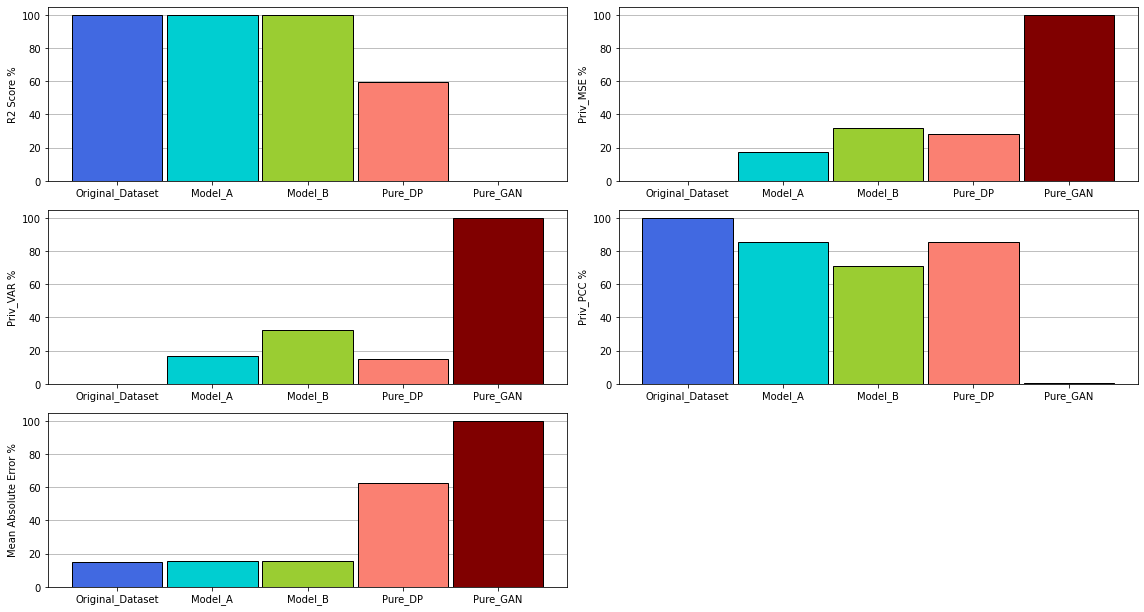

In [25]:
###NORMALIZED
fig = plt.figure(figsize=(16, 14))
ax1 = plt.subplot(5, 2, 1)
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='R2_Score']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width)
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")    
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('R2 Score %')

ax2 = plt.subplot(5, 2, 2)
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 1: MSE']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_MSE %')

ax3 = plt.subplot(5, 2, 3)
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 2: Norm.Var']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_VAR %')

ax4 = plt.subplot(5, 2, 4)
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 3: PearsonCC']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_PCC %')

ax5 = plt.subplot(5, 2, 5)
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='MAE']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Mean Absolute Error %')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5) 
plt.tight_layout()
plt.show();


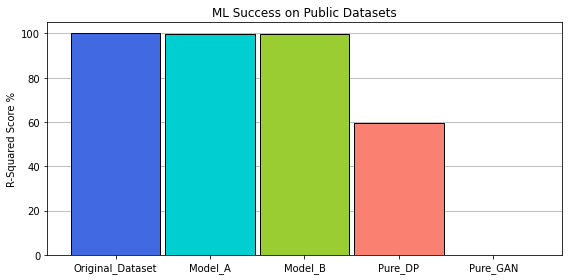

In [43]:
##NORMALIZED
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.set_title('ML Success on Public Datasets') 
plt_data = plot_df_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='R2_Score']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width)
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")    
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('R-Squared Score %')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5) 
plt.tight_layout()
plt.show();


In [27]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("R-Squared vs PM1", "R-Squared vs PM2", "R-Squared vs PM3"),
    #vertical_spacing=0.1,
    specs=[[{"type": "polar"}, {"type": "polar"}, {"type": "polar"}]],)

categories = ['O.Data', 'Mdl A', 'Mdl B', 'DP', 'GAN']

fig.add_trace(go.Scatterpolar(r=plot_df_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='bottom right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=1)

fig.add_trace(go.Scatterpolar(r=plot_df_norm.Priv_Metric_1, theta=categories, name='Priv_Metric_1',
                            subplot = "polar1", mode='lines+text+markers', 
                            textposition=['top center','top center','top center','top center','middle left'], 
                            texttemplate=['','','PM1','','bestPM1'],
                            textfont={'size': [1,1,14,1,10], 'color': ["maroon","maroon","maroon","maroon","green"]}, 
                            marker = dict(color='maroon'), marker_symbol = "square",
                            line_color='maroon', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=1)

fig.add_trace(go.Scatterpolar(r=plot_df_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='bottom right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=2)

fig.add_trace(go.Scatterpolar(r=plot_df_norm.Priv_Metric_2, theta=categories, name='Priv_Metric_2',
                            subplot = "polar3", mode='lines+text+markers', 
                            textposition=['top center','top center','top center','top center','middle left'], 
                            texttemplate=['','','PM2','','bestPM2'],
                            textfont={'size': [1,1,14,1,10], 'color': ["salmon","salmon","salmon","salmon","green"]},                              
                            marker = dict(color='salmon'),  marker_symbol = "square",
                            line_color='salmon', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=2)

fig.add_trace(go.Scatterpolar(r=plot_df_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='bottom right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=3)

fig.add_trace(go.Scatterpolar(r=plot_df_norm.Priv_Metric_3, theta=categories, name='Priv_Metric_3',
                            subplot = "polar5", mode='lines+text+markers', 
                            textposition=['bottom center','bottom center','bottom right','bottom center','middle left'], 
                            texttemplate=['','','PM3','','bestPM3'],
                            textfont={'size': [1,1,14,1,10], 'color': ["orange","orange","orange","orange","green"]},                              
                            marker = dict(color='orange'),  marker_symbol = "square",
                            line_color='orange', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=3)

fig['layout'].update(title='Public Dataset Test Results')
fig.update_annotations(font_size=16, font_color='darkblue')

fig.update_layout(
                  height=450, width=1000, 
                  #legend=dict(yanchor="top", y=0.05, xanchor="left", x=0.5),
                  showlegend=False,legend_bordercolor='black',legend_borderwidth=1,
                    polar=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar1=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar2=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar3=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar4=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar5=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                  )


fig.show()

## CASE STUDY: Adversarial Attack and Success of the Model


Xtoy_train_A1.shape: (6924, 6) ; ytoy_train_A1.shape: (6924, 1) ; Xtoy_test_A1.shape: (1731, 6) ; ytoy_test_A1.shape: (1731, 1)
intercept_A1 [0.02122124] coefficients_A1 [[-0.68291714  0.60091535 -0.25073907  0.54054142 -0.1099886   0.09363052]] coefftoy_A1.shape (1, 6) R2 score Public Dataset A1: 0.926011641025962 mean_absolute_error_A1: 0.04534115974023303


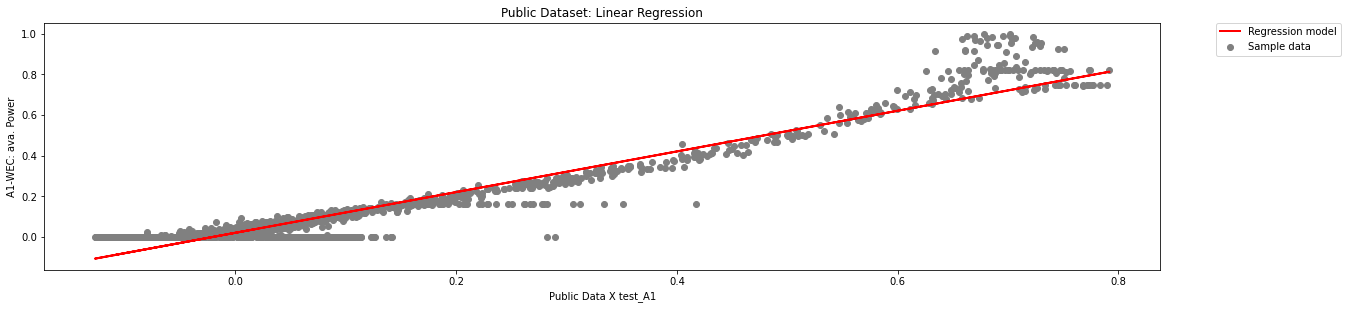

In [28]:
# A1: Adversarial Attack on the original data: Changing Target feature to predict possible WEC: average Power

#Linear Regression
ytoy_A1 = Toy_data[['WEC: ava. Power']]
Xtoy_A1 = Toy_data[['WEC: ava. windspeed', 'WEC: ava. Rotation', 
                 'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours','WEC: Production kWh']]
Toy_data_A1 = pd.concat( [Xtoy_A1.reset_index(), ytoy_A1.reset_index()], axis=1)
del Toy_data_A1['index']
Xtoy_train_A1, Xtoy_test_A1, ytoy_train_A1, ytoy_test_A1 = train_test_split(Xtoy_A1, ytoy_A1, test_size=0.2, random_state=0)
print('Xtoy_train_A1.shape:', Xtoy_train_A1.shape, '; ytoy_train_A1.shape:', ytoy_train_A1.shape, 
      '; Xtoy_test_A1.shape:', Xtoy_test_A1.shape, '; ytoy_test_A1.shape:', ytoy_test_A1.shape)

#Linear Regression for Toy Dataset
lin_regtoy_A1 = LinearRegression()  
reg_modeltoy_A1 = lin_regtoy_A1.fit(Xtoy_train_A1, ytoy_train_A1)
intercepttoy_A1 = lin_regtoy_A1.intercept_
coefftoy_A1 = lin_regtoy_A1.coef_
ytoy_pred_A1 = lin_regtoy_A1.predict(Xtoy_test_A1)
r2scoretoy_A1 = reg_modeltoy_A1.score(Xtoy_test_A1, ytoy_test_A1)
#accuracytoy_A1 = reg_modeltoy_A1.score(Xtoy_test_A1, ytoy_test_A1)
MAEtoy_A1 = mean_absolute_error(ytoy_test_A1, ytoy_pred_A1)

print('intercept_A1', intercepttoy_A1, 
      'coefficients_A1', coefftoy_A1, 
      'coefftoy_A1.shape', coefftoy_A1.shape,
      'R2 score Public Dataset A1:', r2scoretoy_A1,
      'mean_absolute_error_A1:', MAEtoy_A1)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 1, 1)
ax1.set_title('Public Dataset: Linear Regression') 
plt.xlabel('Public Data X test_A1')
plt.ylabel('A1-WEC: ava. Power')
plt.scatter(Xtoy_test_A1.dot(coefftoy_A1.squeeze()), ytoy_test_A1, label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_A1.dot(coefftoy_A1.squeeze()), ytoy_pred_A1, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show();

Xtoy_train_model_0C_A1.shape: (6924, 6) ; ytoy_train_model_0C_A1.shape: (6924, 1) ; Xtoy_test_model_0C_A1.shape: (1731, 6) ; ytoy_test_model_0C_A1.shape: (1731, 1)
intercept_model_A_A1 [0.40064834] coefficients_model_A_A1 [[-0.08823787  0.00164285  0.01523169  0.0354992  -0.03625596  0.02678981]] coefftoy_model_A_A1.shape (1, 6) R2 Score model_A_A1 of Public Dataset: -0.0017704618306626507 mean_absolute_error: 0.2672897983211398


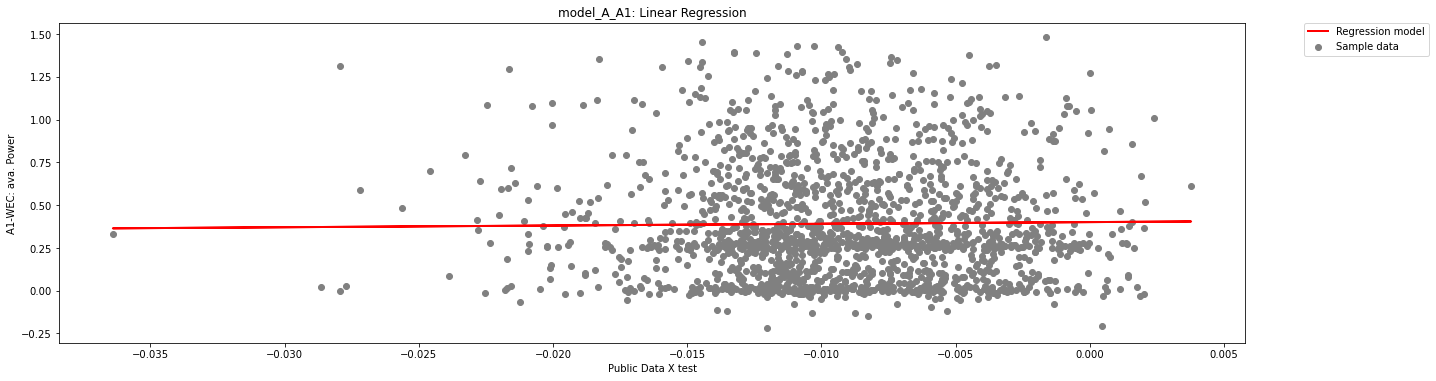

In [29]:
# A1: Adversarial Attack on the model_0C_A1 data: Changing Target feature to predict possible WEC: average Power

#Linear Regression model_0C_A1
ytoy_model_0C_A1 = Toy_model_0C[['WEC: ava. Power']]
Xtoy_model_0C_A1 = Toy_model_0C[['WEC: ava. windspeed', 'WEC: ava. Rotation', 
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours','WEC: Production kWh']]
Toy_model_0C_A1 = pd.concat( [Xtoy_model_0C_A1.reset_index(), ytoy_model_0C_A1.reset_index()], axis=1)
del Toy_model_0C_A1['index']
Xtoy_train_model_0C_A1, Xtoy_test_model_0C_A1, ytoy_train_model_0C_A1, ytoy_test_model_0C_A1 = train_test_split(
    Xtoy_model_0C_A1, ytoy_model_0C_A1, test_size=0.2, random_state=0)
print('Xtoy_train_model_0C_A1.shape:', Xtoy_train_model_0C_A1.shape, '; ytoy_train_model_0C_A1.shape:', ytoy_train_model_0C_A1.shape, 
      '; Xtoy_test_model_0C_A1.shape:', Xtoy_test_model_0C_A1.shape, '; ytoy_test_model_0C_A1.shape:', ytoy_test_model_0C_A1.shape)

#Linear Regression for Toy Dataset model_0C_A1
lin_regtoy_model_0C_A1 = LinearRegression()  
reg_modeltoy_model_0C_A1 = lin_regtoy_model_0C_A1.fit(Xtoy_train_model_0C_A1, ytoy_train_model_0C_A1)
intercepttoy_model_0C_A1 = lin_regtoy_model_0C_A1.intercept_
coefftoy_model_0C_A1 = lin_regtoy_model_0C_A1.coef_
ytoy_pred_model_0C_A1 = lin_regtoy_model_0C_A1.predict(Xtoy_test_model_0C_A1)
r2scoretoy_model_0C_A1 = reg_modeltoy_model_0C_A1.score(Xtoy_test_model_0C_A1, ytoy_test_model_0C_A1)
#accuracytoy_model_0C_A1 = reg_modeltoy_model_0C_A1.score(Xtoy_test_model_0C_A1, ytoy_test_model_0C_A1)
MAEtoy_model_0C_A1 = mean_absolute_error(ytoy_test_model_0C_A1, ytoy_pred_model_0C_A1)
print('intercept_model_A_A1', intercepttoy_model_0C_A1, 
      'coefficients_model_A_A1', coefftoy_model_0C_A1, 
      'coefftoy_model_A_A1.shape', coefftoy_model_0C_A1.shape,
      'R2 Score model_A_A1 of Public Dataset:', r2scoretoy_model_0C_A1,
      'mean_absolute_error:', MAEtoy_model_0C_A1)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('model_A_A1: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('A1-WEC: ava. Power')
plt.scatter(Xtoy_test_model_0C_A1.dot(coefftoy_model_0C_A1.squeeze()), ytoy_test_model_0C_A1, 
            label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_model_0C_A1.dot(coefftoy_model_0C_A1.squeeze()), ytoy_pred_model_0C_A1, 
         label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

Xtoy_train_model_2C_A1.shape: (6924, 6) ; ytoy_train_model_2C_A1.shape: (6924, 1) ; Xtoy_test_model_2C_A1.shape: (1731, 6) ; ytoy_test_model_2C_A1.shape: (1731, 1)
intercept_model_B_A1 [0.38117613] coefficients_model_B_A1 [[-0.08691805  0.00668685  0.03975523  0.03775996 -0.03912778  0.03272905]] coefftoy_model_B_A1.shape (1, 6) R2 Score model_B_A1 of Public Dataset: -0.002808843155744034 mean_absolute_error: 0.26499396873585535


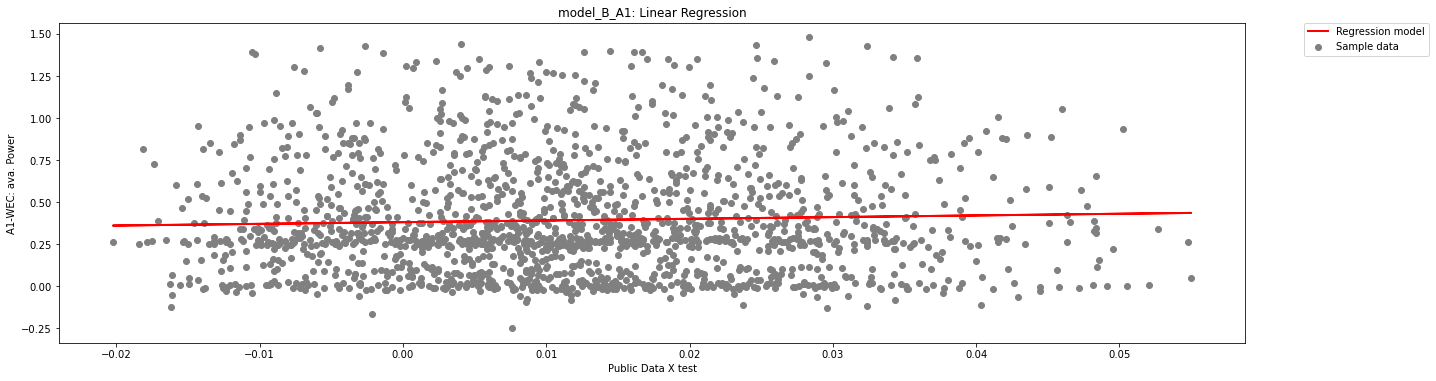

In [30]:
# A1: Adversarial Attack on the model_2C_A1 data: Changing Target feature to predict possible WEC: average Power

#Linear Regression model_2C_A1
ytoy_model_2C_A1 = Toy_model_2C[['WEC: ava. Power']]
Xtoy_model_2C_A1 = Toy_model_2C[['WEC: ava. windspeed', 'WEC: ava. Rotation', 
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours','WEC: Production kWh']]
Toy_model_2C_A1 = pd.concat( [Xtoy_model_2C_A1.reset_index(), ytoy_model_2C_A1.reset_index()], axis=1)
del Toy_model_2C_A1['index']
Xtoy_train_model_2C_A1, Xtoy_test_model_2C_A1, ytoy_train_model_2C_A1, ytoy_test_model_2C_A1 = train_test_split(
    Xtoy_model_2C_A1, ytoy_model_2C_A1, test_size=0.2, random_state=0)
print('Xtoy_train_model_2C_A1.shape:', Xtoy_train_model_2C_A1.shape, '; ytoy_train_model_2C_A1.shape:', ytoy_train_model_2C_A1.shape, 
      '; Xtoy_test_model_2C_A1.shape:', Xtoy_test_model_2C_A1.shape, '; ytoy_test_model_2C_A1.shape:', ytoy_test_model_2C_A1.shape)

#Linear Regression for Toy Dataset model_2C_A1
lin_regtoy_model_2C_A1 = LinearRegression()  
reg_modeltoy_model_2C_A1 = lin_regtoy_model_2C_A1.fit(Xtoy_train_model_2C_A1, ytoy_train_model_2C_A1)
intercepttoy_model_2C_A1 = lin_regtoy_model_2C_A1.intercept_
coefftoy_model_2C_A1 = lin_regtoy_model_2C_A1.coef_
ytoy_pred_model_2C_A1 = lin_regtoy_model_2C_A1.predict(Xtoy_test_model_2C_A1)
r2scoretoy_model_2C_A1 = reg_modeltoy_model_2C_A1.score(Xtoy_test_model_2C_A1, ytoy_test_model_2C_A1)
#accuracytoy_model_2C_A1 = reg_modeltoy_model_2C_A1.score(Xtoy_test_model_2C_A1, ytoy_test_model_2C_A1)
MAEtoy_model_2C_A1 = mean_absolute_error(ytoy_test_model_2C_A1, ytoy_pred_model_2C_A1)
print('intercept_model_B_A1', intercepttoy_model_2C_A1, 
      'coefficients_model_B_A1', coefftoy_model_2C_A1, 
      'coefftoy_model_B_A1.shape', coefftoy_model_2C_A1.shape,
      'R2 Score model_B_A1 of Public Dataset:', r2scoretoy_model_2C_A1,
      'mean_absolute_error:', MAEtoy_model_2C_A1)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('model_B_A1: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('A1-WEC: ava. Power')
plt.scatter(Xtoy_test_model_2C_A1.dot(coefftoy_model_2C_A1.squeeze()), ytoy_test_model_2C_A1, 
            label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_model_2C_A1.dot(coefftoy_model_2C_A1.squeeze()), ytoy_pred_model_2C_A1, 
         label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

Xtoy_train_DP_A1.shape: (6924, 6) ; ytoy_train_DP_A1.shape: (6924, 1) ; Xtoy_test_DP_A1.shape: (1731, 6) ; ytoy_test_DP_A1.shape: (1731, 1)
intercept_DP_A1 [-0.12140532] coefficients_DP_A1 [[ 0.03953288  0.35051229 -0.10075895  0.34161174  0.02650337  0.02960088]] coefftoy_DP_A1.shape (1, 6) r2score DP of Public Dataset: 0.6437004959210739 mean_absolute_error: 0.11602751985846257


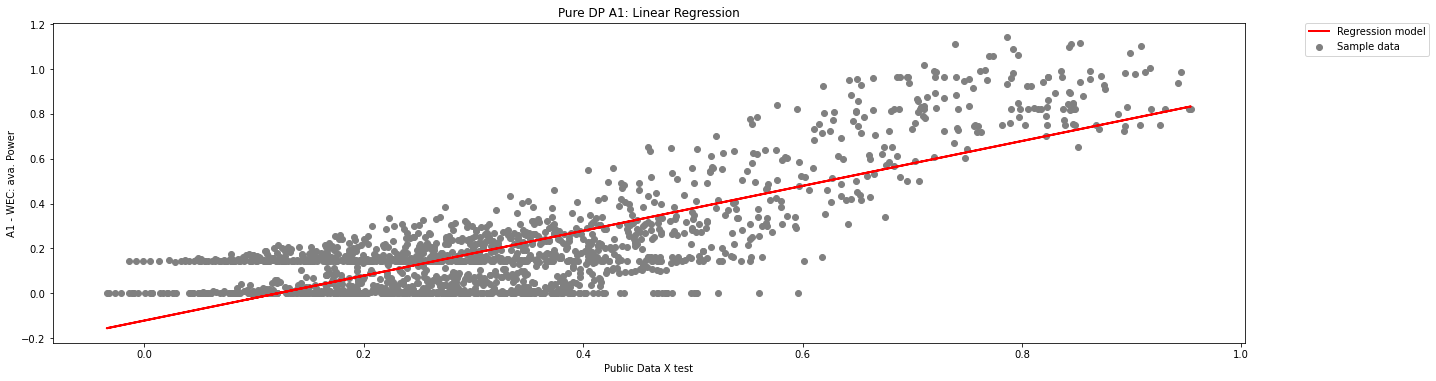

In [31]:
# A1: Adversarial Attack on the toy_DP_A1_A1 data: Changing Target feature to predict possible WEC: average Power


#Linear Regression DP
ytoy_DP_A1 = Toy_data_DP[['WEC: ava. Power']]
Xtoy_DP_A1 = Toy_data_DP[['WEC: ava. windspeed', 'WEC: ava. Rotation', 
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours','WEC: Production kWh']]
Toy_data_DP_A1 = pd.concat( [Xtoy_DP_A1.reset_index(), ytoy_DP_A1.reset_index()], axis=1)
del Toy_data_DP_A1['index']
Xtoy_train_DP_A1, Xtoy_test_DP_A1, ytoy_train_DP_A1, ytoy_test_DP_A1 = train_test_split(Xtoy_DP_A1, ytoy_DP_A1, test_size=0.2, random_state=0)
print('Xtoy_train_DP_A1.shape:', Xtoy_train_DP_A1.shape, '; ytoy_train_DP_A1.shape:', ytoy_train_DP_A1.shape, 
      '; Xtoy_test_DP_A1.shape:', Xtoy_test_DP_A1.shape, '; ytoy_test_DP_A1.shape:', ytoy_test_DP_A1.shape)

#Linear Regression for Toy Dataset DP
lin_regtoy_DP_A1 = LinearRegression()  
reg_modeltoy_DP_A1 = lin_regtoy_DP_A1.fit(Xtoy_train_DP_A1, ytoy_train_DP_A1)
intercepttoy_DP_A1 = lin_regtoy_DP_A1.intercept_
coefftoy_DP_A1 = lin_regtoy_DP_A1.coef_
ytoy_pred_DP_A1 = lin_regtoy_DP_A1.predict(Xtoy_test_DP_A1)
r2scoretoy_DP_A1 = reg_modeltoy_DP_A1.score(Xtoy_test_DP_A1, ytoy_test_DP_A1)
#accuracytoy_DP_A1 = reg_modeltoy_DP_A1.score(Xtoy_test_DP_A1, ytoy_test_DP_A1)
MAEtoy_DP_A1 = mean_absolute_error(ytoy_test_DP_A1, ytoy_pred_DP_A1)

print('intercept_DP_A1', intercepttoy_DP_A1, 
      'coefficients_DP_A1', coefftoy_DP_A1, 
      'coefftoy_DP_A1.shape', coefftoy_DP_A1.shape,
      'r2score DP of Public Dataset:', r2scoretoy_DP_A1,
      'mean_absolute_error:',MAEtoy_DP_A1)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Pure DP A1: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('A1 - WEC: ava. Power')
plt.scatter(Xtoy_test_DP_A1.dot(coefftoy_DP_A1.squeeze()), ytoy_test_DP_A1, label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_DP_A1.dot(coefftoy_DP_A1.squeeze()), ytoy_pred_DP_A1, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

Xtoy_train_GAN_A1.shape: (6924, 6) ; ytoy_train_GAN_A1.shape: (6924, 1) ; Xtoy_test_GAN_A1.shape: (1731, 6) ; ytoy_test_GAN_A1.shape: (1731, 1)
intercept_GAN_A1 [0.20445607] coefficients_GAN_A1 [[ 0.04464639  0.04482099  0.04450391 -0.00252932 -0.00952763  0.02471297]] coefftoy_GAN_A1.shape (1, 6) r2score GAN of Public Dataset: -0.0009007332984836136 mean_absolute_error: 0.25043559843714336


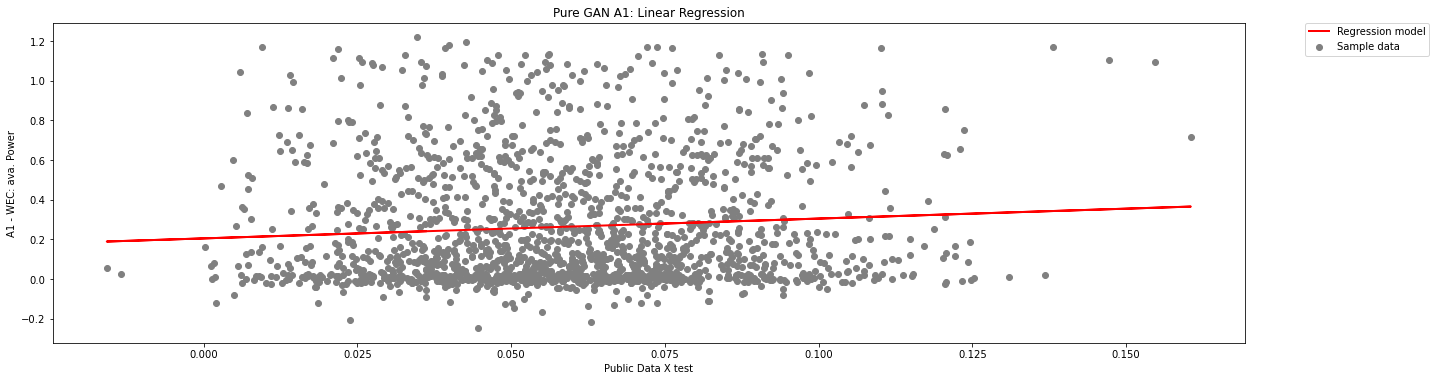

In [32]:
# A1: Adversarial Attack on the toy_GAN_A1 data: Changing Target feature to predict possible WEC: average Power


#Linear Regression GAN
ytoy_GAN_A1 = Toy_data_GAN[['WEC: ava. Power']]
Xtoy_GAN_A1 = Toy_data_GAN[['WEC: ava. windspeed', 'WEC: ava. Rotation', 
          'WEC: ava. reactive Power', 'WEC: ava. available P from wind','WEC: Operating Hours','WEC: Production kWh']]
Toy_data_GAN_A1 = pd.concat( [Xtoy_GAN_A1.reset_index(), ytoy_GAN_A1.reset_index()], axis=1)
del Toy_data_GAN_A1['index']
Xtoy_train_GAN_A1, Xtoy_test_GAN_A1, ytoy_train_GAN_A1, ytoy_test_GAN_A1 = train_test_split(Xtoy_GAN_A1, ytoy_GAN_A1, test_size=0.2, random_state=0)
print('Xtoy_train_GAN_A1.shape:', Xtoy_train_GAN_A1.shape, '; ytoy_train_GAN_A1.shape:', ytoy_train_GAN_A1.shape, 
      '; Xtoy_test_GAN_A1.shape:', Xtoy_test_GAN_A1.shape, '; ytoy_test_GAN_A1.shape:', ytoy_test_GAN_A1.shape)

#Linear Regression for Toy Dataset GAN
lin_regtoy_GAN_A1 = LinearRegression()  
reg_modeltoy_GAN_A1 = lin_regtoy_GAN_A1.fit(Xtoy_train_GAN_A1, ytoy_train_GAN_A1)
intercepttoy_GAN_A1 = lin_regtoy_GAN_A1.intercept_
coefftoy_GAN_A1 = lin_regtoy_GAN_A1.coef_
ytoy_pred_GAN_A1 = lin_regtoy_GAN_A1.predict(Xtoy_test_GAN_A1)
r2scoretoy_GAN_A1 = reg_modeltoy_GAN_A1.score(Xtoy_test_GAN_A1, ytoy_test_GAN_A1)
MAEtoy_GAN_A1 = mean_absolute_error(ytoy_test_GAN_A1, ytoy_pred_GAN_A1)

print('intercept_GAN_A1', intercepttoy_GAN_A1, 
      'coefficients_GAN_A1', coefftoy_GAN_A1, 
      'coefftoy_GAN_A1.shape', coefftoy_GAN_A1.shape,
      'r2score GAN of Public Dataset:', r2scoretoy_GAN_A1,
      'mean_absolute_error:',MAEtoy_GAN_A1)

#The Toy Data and Features
fig = plt.figure(figsize=(20, 10))
ax2 = plt.subplot(2, 1, 1)
ax2.set_title('Pure GAN A1: Linear Regression') 
plt.xlabel('Public Data X test')
plt.ylabel('A1 - WEC: ava. Power')
plt.scatter(Xtoy_test_GAN_A1.dot(coefftoy_GAN_A1.squeeze()), ytoy_test_GAN_A1, label= 'Sample data',  color='gray')
plt.plot(Xtoy_test_GAN_A1.dot(coefftoy_GAN_A1.squeeze()), ytoy_pred_GAN_A1, label= 'Regression model', color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

In [33]:
Toy_data_test_A1 = pd.DataFrame([])

PM_df = Privacy_Metric(Toy_data, Toy_data_A1)
PM_df['Model_Name'] = 'Public_data_A1'
PM_df['R2_Score'] = abs(r2scoretoy_A1)
PM_df['MAE'] = abs(MAEtoy_A1)
Toy_data_test_A1 = Toy_data_test_A1.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data, Toy_data_GAN_A1)
PM_df['Model_Name'] = 'Public_data_GAN_A1'
PM_df['R2_Score'] = abs(r2scoretoy_GAN_A1)
PM_df['MAE'] = abs(MAEtoy_GAN_A1)
Toy_data_test_A1 = Toy_data_test_A1.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data, Toy_data_DP_A1)
PM_df['Model_Name'] = 'Public_data_DP_A1'
PM_df['R2_Score'] = abs(r2scoretoy_DP_A1)
PM_df['MAE'] = abs(MAEtoy_DP_A1)
Toy_data_test_A1 = Toy_data_test_A1.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data,Toy_model_0C_A1)
PM_df['Model_Name'] = 'Public_model_A_A1'
PM_df['R2_Score'] = abs(r2scoretoy_model_0C_A1)
PM_df['MAE'] = abs(MAEtoy_model_0C_A1)
Toy_data_test_A1 = Toy_data_test_A1.append(PM_df, ignore_index=True)

PM_df = Privacy_Metric(Toy_data,Toy_model_2C_A1)
PM_df['Model_Name'] = 'Public_model_B_A1'
PM_df['R2_Score'] = abs(r2scoretoy_model_2C_A1)
PM_df['MAE'] = abs(MAEtoy_model_2C_A1)
Toy_data_test_A1 = Toy_data_test_A1.append(PM_df, ignore_index=True)

Toy_data_test_A1

F_Nb   PDF_1   PDF_2  PDF_Diff_Perc  MeanSqErr  NormVar  PearsonCC  \
0      0  151.84  151.84           0.00       0.00     0.00       1.00   
1      1  509.12  509.12           0.00       0.00     0.00       1.00   
2      2  135.23  360.62           1.67       0.18     2.49      -0.26   
3      3  360.62  279.19           0.23       0.22     3.82      -0.51   
4      4  279.19  540.94           0.94       0.26     2.86      -0.24   
5      5  540.94  577.00           0.07       0.01     0.06       0.98   
6      6  577.00  135.23           0.77       0.25     1.22       0.14   
7      0  151.84  210.02           0.38       0.08     4.53       0.03   
8      1  509.12  458.37           0.10       0.21     2.23       0.00   
9      2  135.23  366.56           1.71       0.18     2.36      -0.01   
10     3  360.62  535.13           0.48       0.19     3.54       0.00   
11     4  279.19  495.36           0.77       0.22     2.34       0.01   
12     5  540.94  525.29           0.03       0.25     2.21      -0.01   
13     6  577.00  351.77           0.39       0.27     1.69      -0.01   
14     0  151.84  214.87           0.42       0.03     0.88       0.73   
15     1  509.12  395.53           0.22       0.09     0.47       0.82   
16     2  135.23  373.61           1.76       0.32     3.07      -0.20   
17     3  360.62  337.84           0.06       0.23     4.17      -0.47   
18     4  279.19  510.72           0.83       0.47     3.81      -0.20   
19     5  540.94  443.30           0.18       0.07     0.33       0.87   
20     6  577.00  190.54           0.67       0.22     1.26       0.13   
21     0  151.84  151.84           0.00       0.00     0.00       1.00   
22     1  509.12  509.12           0.00       0.00     0.00       1.00   
23     2  135.23  360.62           1.67       0.18     2.49      -0.26   
24     3  360.62  279.19           0.23       0.22     3.82      -0.51   
25     4  279.19  540.94           0.94       0.26     2.86      -0.24   
26     5  540.94  577.00           0.07       0.01     0.06       0.98   
27     6  577.00  365.67           0.37       0.26     1.81      -0.01   
28     0  151.84  151.84           0.00       0.00     0.00       1.00   
29     1  509.12  509.12           0.00       0.00     0.00       1.00   
30     2  135.23  391.46           1.89       0.33     2.94      -0.00   
31     3  360.62  279.19           0.23       0.22     3.82      -0.51   
32     4  279.19  540.94           0.94       0.26     2.86      -0.24   
33     5  540.94  577.00           0.07       0.01     0.06       0.98   
34     6  577.00  363.51           0.37       0.26     1.81      -0.01   

            Model_Name  R2_Score       MAE  
0       Public_data_A1  0.926012  0.045341  
1       Public_data_A1  0.926012  0.045341  
2       Public_data_A1  0.926012  0.045341  
3       Public_data_A1  0.926012  0.045341  
4       Public_data_A1  0.926012  0.045341  
5       Public_data_A1  0.926012  0.045341  
6       Public_data_A1  0.926012  0.045341  
7   Public_data_GAN_A1  0.000901  0.250436  
8   Public_data_GAN_A1  0.000901  0.250436  
9   Public_data_GAN_A1  0.000901  0.250436  
10  Public_data_GAN_A1  0.000901  0.250436  
11  Public_data_GAN_A1  0.000901  0.250436  
12  Public_data_GAN_A1  0.000901  0.250436  
13  Public_data_GAN_A1  0.000901  0.250436  
14   Public_data_DP_A1  0.643700  0.116028  
15   Public_data_DP_A1  0.643700  0.116028  
16   Public_data_DP_A1  0.643700  0.116028  
17   Public_data_DP_A1  0.643700  0.116028  
18   Public_data_DP_A1  0.643700  0.116028  
19   Public_data_DP_A1  0.643700  0.116028  
20   Public_data_DP_A1  0.643700  0.116028  
21   Public_model_A_A1  0.001770  0.267290  
22   Public_model_A_A1  0.001770  0.267290  
23   Public_model_A_A1  0.001770  0.267290  
24   Public_model_A_A1  0.001770  0.267290  
25   Public_model_A_A1  0.001770  0.267290  
26   Public_model_A_A1  0.001770  0.267290  
27   Public_model_A_A1  0.001770  0.267290  
28   Public_model_B_A1  0.002809  

In [34]:
plot_df_A1 = pd.DataFrame([])

#Toy_data
Priv1 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_A1'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_A1'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_A1'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Public Dataset', abs(r2scoretoy_A1), (MAEtoy_A1), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df_A1 = plot_df_A1.append(pm_df, ignore_index=True)

#Toy_model_0C: model A
Priv1 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_A_A1'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_A_A1'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_A_A1'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Model A', abs(r2scoretoy_model_0C_A1), (MAEtoy_model_0C_A1), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df_A1 = plot_df_A1.append(pm_df, ignore_index=True)

#Toy_model_2C :model B
Priv1 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_B_A1'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_B_A1'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_model_B_A1'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Model B', abs(r2scoretoy_model_2C_A1), (MAEtoy_model_2C_A1), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df_A1 = plot_df_A1.append(pm_df, ignore_index=True)

#Toy_data_DP
Priv1 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_DP_A1'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_DP_A1'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_DP_A1'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Pure DP', abs(r2scoretoy_DP_A1), (MAEtoy_DP_A1), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df_A1 = plot_df_A1.append(pm_df, ignore_index=True)

#Toy_data_GAN
Priv1 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_GAN_A1'][['MeanSqErr']].mean().squeeze(),4)
Priv2 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_GAN_A1'][['NormVar']].mean().squeeze(),4)
Priv3 = round(Toy_data_test_A1.loc[Toy_data_test_A1['Model_Name']=='Public_data_GAN_A1'][['PearsonCC']].mean().squeeze(),4)
pm_df =pd.DataFrame([['Pure GAN', abs(r2scoretoy_GAN_A1), (MAEtoy_GAN_A1), Priv1, Priv2, Priv3]],
                    columns=['Model_Name', 'R2_Score', 'MAE', 'Priv_Metric_1', 'Priv_Metric_2', 'Priv_Metric_3'],dtype=float)
plot_df_A1 = plot_df_A1.append(pm_df, ignore_index=True)

plot_df_A1_chng = pd.DataFrame([])

#R2_score
m_dataset = abs(r2scoretoy_A1)
m_modela = abs(r2scoretoy_model_0C_A1)
m_modelb = abs(r2scoretoy_model_2C_A1)
m_dp = abs(r2scoretoy_DP_A1)
m_gan = abs(r2scoretoy_GAN_A1)
pm_df =pd.DataFrame([['R2_Score', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_A1_chng = plot_df_A1_chng.append(pm_df, ignore_index=True)

#MAE
m_dataset = abs(MAEtoy_A1)
m_modela = abs(MAEtoy_model_0C_A1)
m_modelb = abs(MAEtoy_model_2C_A1)
m_dp = abs(MAEtoy_DP_A1)
m_gan = abs(MAEtoy_GAN_A1)
pm_df =pd.DataFrame([['MAE', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_A1_chng = plot_df_A1_chng.append(pm_df, ignore_index=True)


#Priv 1
m_dataset = plot_df_A1.loc[plot_df_A1['Model_Name']=='Public Dataset']['Priv_Metric_1'].squeeze()
m_modela = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model A']['Priv_Metric_1'].squeeze()
m_modelb = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model B']['Priv_Metric_1'].squeeze()
m_dp = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure DP']['Priv_Metric_1'].squeeze()
m_gan = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure GAN']['Priv_Metric_1'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 1: MSE', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_A1_chng = plot_df_A1_chng.append(pm_df, ignore_index=True)

#Priv 2
m_dataset = plot_df_A1.loc[plot_df_A1['Model_Name']=='Public Dataset']['Priv_Metric_2'].squeeze()
m_modela = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model A']['Priv_Metric_2'].squeeze()
m_modelb = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model B']['Priv_Metric_2'].squeeze()
m_dp = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure DP']['Priv_Metric_2'].squeeze()
m_gan = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure GAN']['Priv_Metric_2'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 2: Norm.Var', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_A1_chng = plot_df_A1_chng.append(pm_df, ignore_index=True)

#Priv 3
m_dataset = plot_df_A1.loc[plot_df_A1['Model_Name']=='Public Dataset']['Priv_Metric_3'].squeeze()
m_modela = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model A']['Priv_Metric_3'].squeeze()
m_modelb = plot_df_A1.loc[plot_df_A1['Model_Name']=='Model B']['Priv_Metric_3'].squeeze()
m_dp = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure DP']['Priv_Metric_3'].squeeze()
m_gan = plot_df_A1.loc[plot_df_A1['Model_Name']=='Pure GAN']['Priv_Metric_3'].squeeze()
pm_df =pd.DataFrame([['Priv Metric 3: PearsonCC', m_dataset, m_modela, m_modelb, m_dp, m_gan]],
                    columns=['Model_Name', 'Original_Dataset', 'Model_A', 'Model_B', 'Pure_DP','Pure_GAN'],dtype=float)
plot_df_A1_chng = plot_df_A1_chng.append(pm_df, ignore_index=True)

plot_df_A1_norm = plot_df_A1.copy()
plot_df_A1_norm.R2_Score = plot_df_A1.R2_Score/plot_df_A1.R2_Score.max()  
plot_df_A1_norm.MAE = plot_df_A1.MAE/plot_df_A1.MAE.max() 
plot_df_A1_norm.Priv_Metric_1 = plot_df_A1.Priv_Metric_1/plot_df_A1.Priv_Metric_1.max() 
plot_df_A1_norm.Priv_Metric_2 = plot_df_A1.Priv_Metric_2/plot_df_A1.Priv_Metric_2.max() 
plot_df_A1_norm.Priv_Metric_3 = plot_df_A1.Priv_Metric_3/plot_df_A1.Priv_Metric_3.max() 



plot_df_A1_chng_norm = plot_df_A1_chng.copy()
plot_df_A1_chng_norm.iloc[0,1:] = plot_df_A1_chng.iloc[0,1:]/plot_df_A1_chng.iloc[0,1:].max()
plot_df_A1_chng_norm.iloc[1,1:] = plot_df_A1_chng.iloc[1,1:]/plot_df_A1_chng.iloc[1,1:].max()
plot_df_A1_chng_norm.iloc[2,1:] = plot_df_A1_chng.iloc[2,1:]/plot_df_A1_chng.iloc[2,1:].max()
plot_df_A1_chng_norm.iloc[3,1:] = plot_df_A1_chng.iloc[3,1:]/plot_df_A1_chng.iloc[3,1:].max()
plot_df_A1_chng_norm.iloc[4,1:] = plot_df_A1_chng.iloc[4,1:]/plot_df_A1_chng.iloc[4,1:].max()



In [35]:
plot_df_A1_chng

Model_Name  Original_Dataset  Model_A   Model_B   Pure_DP  \
0                  R2_Score          0.926012  0.00177  0.002809  0.643700   
1                       MAE          0.045341  0.26729  0.264994  0.116028   
2        Priv Metric 1: MSE          0.131400  0.13290  0.154300  0.204300   
3   Priv Metric 2: Norm.Var          1.492900  1.57710  1.641400  1.998600   
4  Priv Metric 3: PearsonCC          0.301400  0.28000  0.317100  0.240000   

   Pure_GAN  
0  0.000901  
1  0.250436  
2  0.200000  
3  2.700000  
4  0.001400

In [36]:
plot_df_A1_chng_norm

Model_Name  Original_Dataset   Model_A   Model_B   Pure_DP  \
0                  R2_Score          1.000000  0.001912  0.003033  0.695132   
1                       MAE          0.169633  1.000000  0.991411  0.434089   
2        Priv Metric 1: MSE          0.643172  0.650514  0.755262  1.000000   
3   Priv Metric 2: Norm.Var          0.552926  0.584111  0.607926  0.740222   
4  Priv Metric 3: PearsonCC          0.950489  0.883002  1.000000  0.756859   

   Pure_GAN  
0  0.000973  
1  0.936944  
2  0.978953  
3  1.000000  
4  0.004415

In [37]:
plot_df_A1

Model_Name  R2_Score       MAE  Priv_Metric_1  Priv_Metric_2  \
0  Public Dataset  0.926012  0.045341         0.1314         1.4929   
1         Model A  0.001770  0.267290         0.1329         1.5771   
2         Model B  0.002809  0.264994         0.1543         1.6414   
3         Pure DP  0.643700  0.116028         0.2043         1.9986   
4        Pure GAN  0.000901  0.250436         0.2000         2.7000   

   Priv_Metric_3  
0         0.3014  
1         0.2800  
2         0.3171  
3         0.2400  
4         0.0014

In [38]:
plot_df_A1_norm

Model_Name  R2_Score       MAE  Priv_Metric_1  Priv_Metric_2  \
0  Public Dataset  1.000000  0.169633       0.643172       0.552926   
1         Model A  0.001912  1.000000       0.650514       0.584111   
2         Model B  0.003033  0.991411       0.755262       0.607926   
3         Pure DP  0.695132  0.434089       1.000000       0.740222   
4        Pure GAN  0.000973  0.936944       0.978953       1.000000   

   Priv_Metric_3  
0       0.950489  
1       0.883002  
2       1.000000  
3       0.756859  
4       0.004415

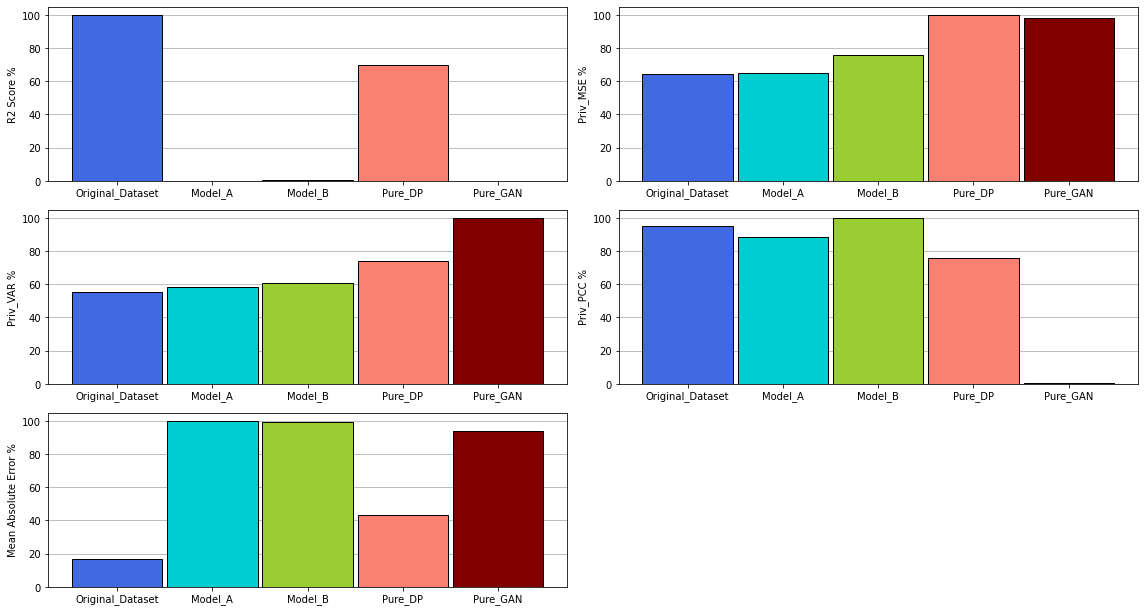

In [39]:
##Normalized

fig = plt.figure(figsize=(16, 14))
ax1 = plt.subplot(5, 2, 1)
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='R2_Score']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width)
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")    
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('R2 Score %')

ax2 = plt.subplot(5, 2, 2)
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 1: MSE']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_MSE %')

ax3 = plt.subplot(5, 2, 3)
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 2: Norm.Var']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_VAR %')

ax4 = plt.subplot(5, 2, 4)
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='Priv Metric 3: PearsonCC']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Priv_PCC %')

ax5 = plt.subplot(5, 2, 5)
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='MAE']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width, alpha=1, edgecolor='black')
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('Mean Absolute Error %')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5) 
plt.tight_layout()
plt.show();


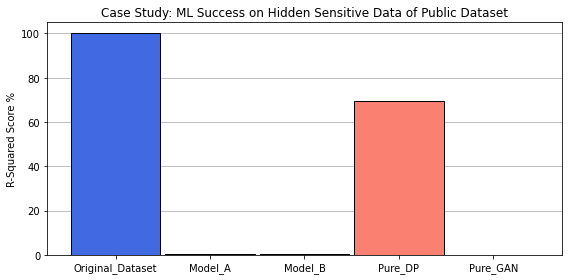

In [44]:
##NORMALIZED
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.set_title('Case Study: ML Success on Hidden Sensitive Data of Public Dataset') 
plt_data = plot_df_A1_chng_norm.copy()
plt_data = plt_data.loc[plt_data['Model_Name']=='R2_Score']
plt_data = plt_data.iloc[:,1:6]*100
width = 0.95
bars=plt.bar(plt_data.columns, plt_data.iloc[:,:].squeeze(), width)
for i, bar in enumerate(bars):  
    if plt_data.columns[i] == 'Original_Dataset': bar.set_color("royalblue"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_A': bar.set_color("darkturquoise"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Model_B': bar.set_color("yellowgreen"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_DP': bar.set_color("salmon"), bar.set_edgecolor("black")
    if plt_data.columns[i] == 'Pure_GAN': bar.set_color("maroon"), bar.set_edgecolor("black")    
axes = plt.gca()
axes.yaxis.grid()
axes.set_axisbelow(True) 
plt.ylabel('R-Squared Score %')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5) 
plt.tight_layout()
plt.show();


In [41]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("R-Squared vs PM1", "R-Squared vs PM2", "R-Squared vs PM3"),
    #vertical_spacing=0.1,
    specs=[[{"type": "polar"}, {"type": "polar"}, {"type": "polar"}]],)

categories = ['O.Data', 'Mdl A', 'Mdl B', 'DP', 'GAN']

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='top right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=1)

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.Priv_Metric_1, theta=categories, name='Priv_Metric_1',
                            subplot = "polar1", mode='lines+text+markers', 
                            textposition=['top center','top center','top center','middle right','top center'], 
                            texttemplate=['','','PM1','bestPM1',''],
                            textfont={'size': [1,1,14,10,1], 'color': ["maroon","maroon","maroon","green","green"]}, 
                            marker = dict(color='maroon'), marker_symbol = "square",
                            line_color='maroon', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=1)

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='top right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=2)

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.Priv_Metric_2, theta=categories, name='Priv_Metric_2',
                            subplot = "polar3", mode='lines+text+markers', 
                            textposition=['top center','top center','top center','top center','top center'], 
                            texttemplate=['','','PM2','','bestPM2'],
                            textfont={'size': [1,1,14,1,10], 'color': ["salmon","salmon","salmon","salmon","green"]},                              
                            marker = dict(color='salmon'),  marker_symbol = "square",
                            line_color='salmon', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=2)

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.R2_Score, theta=categories, name='R-Squared Score', mode='lines+text+markers', 
                            textposition='top right', texttemplate='R-Squared',
                            textfont={'size': [1,1,14], 'color': ["blue","blue","blue","blue","blue"]}, 
                            marker = dict(color='blue'), marker_symbol = "square",
                            line_color='blue', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=3)

fig.add_trace(go.Scatterpolar(r=plot_df_A1_norm.Priv_Metric_3, theta=categories, name='Priv_Metric_3',
                            subplot = "polar5", mode='lines+text+markers', 
                            textposition=['bottom center','bottom center','bottom right','bottom center','middle left'], 
                            texttemplate=['','','PM3','','bestPM3'],
                            textfont={'size': [1,1,14,1,10], 'color': ["orange","orange","orange","orange","green"]},                              
                            marker = dict(color='orange'),  marker_symbol = "square",
                            line_color='orange', line_width=2, line_dash='solid', line_shape = 'spline'), row=1, col=3)

fig['layout'].update(title='Case Study: Public Dataset Results')
fig.update_annotations(font_size=16, font_color='darkblue')

fig.update_layout(
                  height=450, width=1000, 
                  #legend=dict(yanchor="top", y=0.05, xanchor="left", x=0.5),
                  showlegend=False,legend_bordercolor='black',legend_borderwidth=1,
                    polar=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar1=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar2=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar3=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar4=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                    polar5=dict(radialaxis_layer='below traces', radialaxis=dict(visible=True, range=[0,1.1]),),
                  )
fig.show()